In [1]:
import pandas as pd
from clearml import Task
import numpy as np
import h5py
import os
from pathlib import Path
import re
from datetime import datetime
import dask.dataframe as dd
import gc
import pyarrow.parquet as pq
import pyarrow as pa

def find_latest_h5_file(task_id, base_dir="/scratch/clearml/offline_logs/"):
    """Find the latest h5 file for a given task_id"""
    base_path = Path(base_dir)
    
    pattern = f"metrics_{task_id}*.h5"
    matching_files = list(base_path.glob(pattern))
    
    if not matching_files:
        print(f"  No h5 file found for task {task_id}")
        return None
    
    if len(matching_files) == 1:
        print(f"  Found h5 file: {matching_files[0].name}")
        return matching_files[0]
    
    files_with_timestamps = []
    for file_path in matching_files:
        filename = file_path.name
        timestamp_match = re.search(f"metrics_{task_id}_(.+)\\.h5", filename)
        if timestamp_match:
            timestamp_str = timestamp_match.group(1)
            try:
                timestamp = float(timestamp_str)
            except ValueError:
                try:
                    timestamp = datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S").timestamp()
                except:
                    timestamp = float('-inf')
            files_with_timestamps.append((file_path, timestamp))
        else:
            files_with_timestamps.append((file_path, float('-inf')))
    
    latest_file = max(files_with_timestamps, key=lambda x: x[1])[0]
    print(f"  Multiple h5 files found, using latest: {latest_file.name}")
    return latest_file

def debug_h5_structure(h5_path):
    """Debug function to inspect h5 file structure"""
    print(f"\nDEBUGGING H5 FILE: {h5_path}")
    
    with h5py.File(h5_path, 'r') as f:
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}")
                print(f"  Shape: {obj.shape}")
                print(f"  Dtype: {obj.dtype}")
                if obj.size < 10:
                    print(f"  Data preview: {obj[:]}")
                else:
                    print(f"  Data preview (first 5): {obj[:5]}")
        
        print("H5 File Structure:")
        f.visititems(print_structure)
        print(f"\nRoot level keys: {list(f.keys())}")

def read_h5_metrics(h5_path):
    """Read metrics from h5 file and return as structured dictionary"""
    metrics = {}
    
    with h5py.File(h5_path, 'r') as f:
        metric_names = set()
        for key in f.keys():
            if not key.endswith('_iterations'):
                metric_names.add(key)
        
        for metric_name in metric_names:
            iteration_key = f"{metric_name}_iterations"
            
            if metric_name in f:
                values = f[metric_name][:]
                iterations = f[iteration_key][:] if iteration_key in f else None
                
                metrics[metric_name] = {
                    'values': values,
                    'iterations': iterations
                }
    
    return metrics

def download_and_process_tasks_from_h5_normalized(tags, experiment_name, base_dir="/scratch/clearml/offline_logs/", 
                                                   debug_first=True, batch_size=20, 
                                                   metadata_path=None, timeseries_path=None, force_download=False):
    """Download tasks and save as normalized tables: metadata + timeseries"""
    print(f"DOWNLOADING TASKS FOR {experiment_name}: {tags}")
    
    if not metadata_path or not timeseries_path:
        raise ValueError("Both metadata_path and timeseries_path are required")
    
    # Check if files already exist
    if not force_download and os.path.exists(metadata_path) and os.path.exists(timeseries_path):
        print(f"\nFound existing files:")
        print(f"  Metadata: {metadata_path}")
        print(f"  Timeseries: {timeseries_path}")
        print(f"Loading as Dask DataFrames...")
        
        df_metadata = dd.read_parquet(metadata_path)
        df_timeseries = dd.read_parquet(timeseries_path)
        
        print(f"\nMetadata DataFrame: {df_metadata.npartitions} partitions")
        print(f"Columns: {df_metadata.columns.tolist()}")
        print(f"Sample:")
        print(df_metadata.head(5))
        
        print(f"\nTimeseries DataFrame: {df_timeseries.npartitions} partitions")
        print(f"Columns: {df_timeseries.columns.tolist()}")
        print(f"Sample:")
        print(df_timeseries.head(5))
        
        return df_metadata, df_timeseries
    
    if force_download:
        print("Force download enabled - will regenerate files")
    
    # Use query_tasks to get all task IDs - filter for completed tasks
    print("Querying all completed task IDs...")
    task_ids = Task.query_tasks(project_name="oho", tags=tags, task_filter={'status': ['completed'], 'system_tags': ['-archived']})
    print(f"Found {len(task_ids)} completed task IDs (excluding archived)")
    
    # Get full task objects
    print("Loading task objects...")
    tasks = [Task.get_task(task_id=tid) for tid in task_ids]
    print(f"Loaded {len(tasks)} tasks")
    
    print(f"Will save metadata to: {metadata_path}")
    print(f"Will save timeseries to: {timeseries_path}")
    
    # Create directories if they don't exist
    os.makedirs(os.path.dirname(metadata_path), exist_ok=True)
    os.makedirs(os.path.dirname(timeseries_path), exist_ok=True)
    
    # Remove existing files
    if os.path.exists(metadata_path):
        os.remove(metadata_path)
    if os.path.exists(timeseries_path):
        os.remove(timeseries_path)
    
    h5_files_found = 0
    h5_files_missing = 0
    total_metadata_rows = 0
    total_timeseries_rows = 0
    
    metadata_rows = []
    timeseries_writer = None
    
    for batch_start in range(0, len(tasks), batch_size):
        batch_end = min(batch_start + batch_size, len(tasks))
        batch_tasks = tasks[batch_start:batch_end]
        print(f"\nProcessing batch {batch_start + 1}-{batch_end}/{len(tasks)}")
        
        timeseries_rows = []
        
        for idx, task in enumerate(batch_tasks):
            task_id = task.id
            task_name = task.name
            
            # Metadata row (one per task)
            metadata_row = {"task_id": task_id, "task_name": task_name}
            params = task.get_parameters() or {}
            for key, value in params.items():
                # Added momentum to the list of parameters to extract
                if any(x in key for x in ["learning_rate", "optimizer/_type", "seed/global_seed", "weight_decay", "momentum"]):
                    metadata_row[key] = value
            
            h5_path = find_latest_h5_file(task_id, base_dir)
            
            if h5_path is None:
                h5_files_missing += 1
                metadata_rows.append(metadata_row)
                continue
            
            h5_files_found += 1
            
            if debug_first and h5_files_found == 1:
                debug_h5_structure(h5_path)
            
            try:
                metrics = read_h5_metrics(h5_path)
                
                # Separate scalar (final_*) from timeseries
                scalar_metrics = {}
                timeseries_metrics = {}
                
                for metric_name, metric_data in metrics.items():
                    values = metric_data['values']
                    iterations = metric_data['iterations']
                    
                    if metric_name.startswith('final_'):
                        # Add to metadata
                        scalar_metrics[f"metric/{metric_name}"] = values[0] if len(values) > 0 else np.nan
                    elif iterations is not None and len(values) == len(iterations):
                        timeseries_metrics[metric_name] = metric_data
                
                # Add scalar metrics to metadata row
                metadata_row.update(scalar_metrics)
                metadata_rows.append(metadata_row)
                
                # Create timeseries rows (many per task)
                if timeseries_metrics:
                    ref_metric = list(timeseries_metrics.keys())[0]
                    iterations = timeseries_metrics[ref_metric]['iterations']
                    
                    for iter_idx, iteration in enumerate(iterations):
                        ts_row = {
                            "task_id": task_id,
                            "iteration": int(iteration)
                        }
                        
                        for metric_name, metric_data in timeseries_metrics.items():
                            if iter_idx < len(metric_data['values']):
                                ts_row[f"metric/{metric_name}"] = metric_data['values'][iter_idx]
                        
                        timeseries_rows.append(ts_row)
                
                # Free memory immediately after processing each task
                del metrics
                del scalar_metrics
                del timeseries_metrics
                    
            except Exception as e:
                print(f"  ERROR reading h5 file: {e}")
                import traceback
                traceback.print_exc()
                h5_files_missing += 1
                metadata_rows.append(metadata_row)
        
        # Save timeseries batch using streaming writer
        if timeseries_rows:
            ts_batch_df = pd.DataFrame(timeseries_rows)
            total_timeseries_rows += len(ts_batch_df)
            
            if batch_start == 0:
                # Initialize writer on first batch
                ts_table = pa.Table.from_pandas(ts_batch_df)
                timeseries_writer = pq.ParquetWriter(timeseries_path, ts_table.schema)
                timeseries_writer.write_table(ts_table)
                del ts_table
            else:
                # Append to existing file
                ts_table = pa.Table.from_pandas(ts_batch_df)
                timeseries_writer.write_table(ts_table)
                del ts_table
            
            print(f"  Saved timeseries batch ({len(ts_batch_df)} rows)")
            
            del timeseries_rows
            del ts_batch_df
            gc.collect()
    
    # Close the parquet writer
    if timeseries_writer is not None:
        timeseries_writer.close()
    
    # Save all metadata at once (only 300 rows, no need to batch)
    if metadata_rows:
        metadata_df = pd.DataFrame(metadata_rows)
        metadata_df.to_parquet(metadata_path, index=False)
        total_metadata_rows = len(metadata_df)
        print(f"\nSaved metadata ({total_metadata_rows} rows) to {metadata_path}")
        del metadata_df
        gc.collect()
    
    print(f"\n=== SUMMARY ===")
    print(f"Total tasks: {len(tasks)}")
    print(f"H5 files found: {h5_files_found}")
    print(f"H5 files missing: {h5_files_missing}")
    print(f"Total metadata rows: {total_metadata_rows}")
    print(f"Total timeseries rows: {total_timeseries_rows}")
    
    # Load as Dask DataFrames
    print(f"\nLoading as Dask DataFrames")
    df_metadata = dd.read_parquet(metadata_path)
    df_timeseries = dd.read_parquet(timeseries_path)
    
    print(f"\nMetadata DataFrame: {df_metadata.npartitions} partitions")
    print(f"Columns: {df_metadata.columns.tolist()}")
    print(f"Sample:")
    print(df_metadata.head(5))
    
    print(f"\nTimeseries DataFrame: {df_timeseries.npartitions} partitions")
    print(f"Columns: {df_timeseries.columns.tolist()}")
    print(f"Sample:")
    print(df_timeseries.head(5))
    
    return df_metadata, df_timeseries

In [4]:

# Usage
df_metadata_exp1, df_timeseries_exp1 = download_and_process_tasks_from_h5_normalized(
    tags=["opt: 4eb436ba7f3e41fcbc4543223ef74408", "opt: 8220c33ca44b4199a8ae91da29631f99"], 
    experiment_name="Fixed LR",
    base_dir="/scratch/clearml/offline_logs/",
    debug_first=True,
    batch_size=20,
    metadata_path="/scratch/clearml/processed_data/fixed_lr_metadata_4eb436ba7f3e41fcbc4543223ef74408_8220c33ca44b4199a8ae91da29631f99.parquet",
    timeseries_path="/scratch/clearml/processed_data/fixed_lr_timeseries_4eb436ba7f3e41fcbc4543223ef74408_8220c33ca44b4199a8ae91da29631f99.parquet",
    force_download=False,
)


DOWNLOADING TASKS FOR Fixed LR: ['opt: 4eb436ba7f3e41fcbc4543223ef74408', 'opt: 8220c33ca44b4199a8ae91da29631f99']

Found existing files:
  Metadata: /scratch/clearml/processed_data/fixed_lr_metadata_4eb436ba7f3e41fcbc4543223ef74408_8220c33ca44b4199a8ae91da29631f99.parquet
  Timeseries: /scratch/clearml/processed_data/fixed_lr_timeseries_4eb436ba7f3e41fcbc4543223ef74408_8220c33ca44b4199a8ae91da29631f99.parquet
Loading as Dask DataFrames...

Metadata DataFrame: 1 partitions
Columns: ['task_id', 'task_name', 'config/seed/global_seed', 'config/learners/0/learner/momentum1', 'config/learners/0/learner/momentum2', 'config/learners/0/optimizer/learning_rate/value', 'config/learners/0/optimizer/learning_rate/learnable', 'config/learners/0/optimizer/learning_rate/hyperparameter_parametrization/clip', 'config/learners/0/optimizer/learning_rate/hyperparameter_parametrization/scale', 'config/learners/0/optimizer/learning_rate/hyperparameter_parametrization/_type', 'config/learners/0/optimizer/wei

In [2]:

# Usage
df_metadata_exp2, df_timeseries_exp2 = download_and_process_tasks_from_h5_normalized(
    tags=["opt: 232dc6703edb41dda0f82809548996ea"], 
    experiment_name="oho",
    base_dir="/scratch/clearml/offline_logs/",
    debug_first=True,
    batch_size=20,
    metadata_path="/scratch/clearml/processed_data/oho_metadata_232dc6703edb41dda0f82809548996ea.parquet",
    timeseries_path="/scratch/clearml/processed_data/oho_timeseries_232dc6703edb41dda0f82809548996ea.parquet",
    force_download=False,
)


DOWNLOADING TASKS FOR oho: ['opt: 232dc6703edb41dda0f82809548996ea']

Found existing files:
  Metadata: /scratch/clearml/processed_data/oho_metadata_232dc6703edb41dda0f82809548996ea.parquet
  Timeseries: /scratch/clearml/processed_data/oho_timeseries_232dc6703edb41dda0f82809548996ea.parquet
Loading as Dask DataFrames...

Metadata DataFrame: 1 partitions
Columns: ['task_id', 'task_name', 'config/seed/global_seed', 'config/learners/0/learner/momentum2', 'config/learners/0/learner/momentum1', 'config/learners/0/optimizer/learning_rate/value', 'config/learners/0/optimizer/learning_rate/learnable', 'config/learners/0/optimizer/learning_rate/hyperparameter_parametrization/clip', 'config/learners/0/optimizer/learning_rate/hyperparameter_parametrization/a', 'config/learners/0/optimizer/learning_rate/hyperparameter_parametrization/scale', 'config/learners/0/optimizer/learning_rate/hyperparameter_parametrization/b', 'config/learners/0/optimizer/learning_rate/hyperparameter_parametrization/_type'

In [3]:
# Usage
experiments = [
    # ("Fixed LR", df_metadata_exp1, df_timeseries_exp1),
    ("OHO", df_metadata_exp2, df_timeseries_exp2),
]


Processing OHO...
Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']

All configurations ranked by mean final test loss (aggregated across seeds):
--------------------------------------------------------------------------------
Rank 1: learning_rate=0.001000, learning_rate=0.001000, weight_decay=0.000010 | mean=0.365209, std=0.004559, n_seeds=20

********************************************************************************
BEST CONFIG: learning_rate=0.001000, learning_rate=0.001000, weight_decay=0.000010
Mean final test loss: 0.365209
Number of seeds: 20
********************************************************************************

Processing 20 tasks (seeds) for effective learning rate...
  Processed 10/20 tasks
  Processed 20/20 tasks

Best config statistics:
  Final losses: 20 tasks
  Effective LRs: 20 tasks
  Asymptotes: 20 tasks


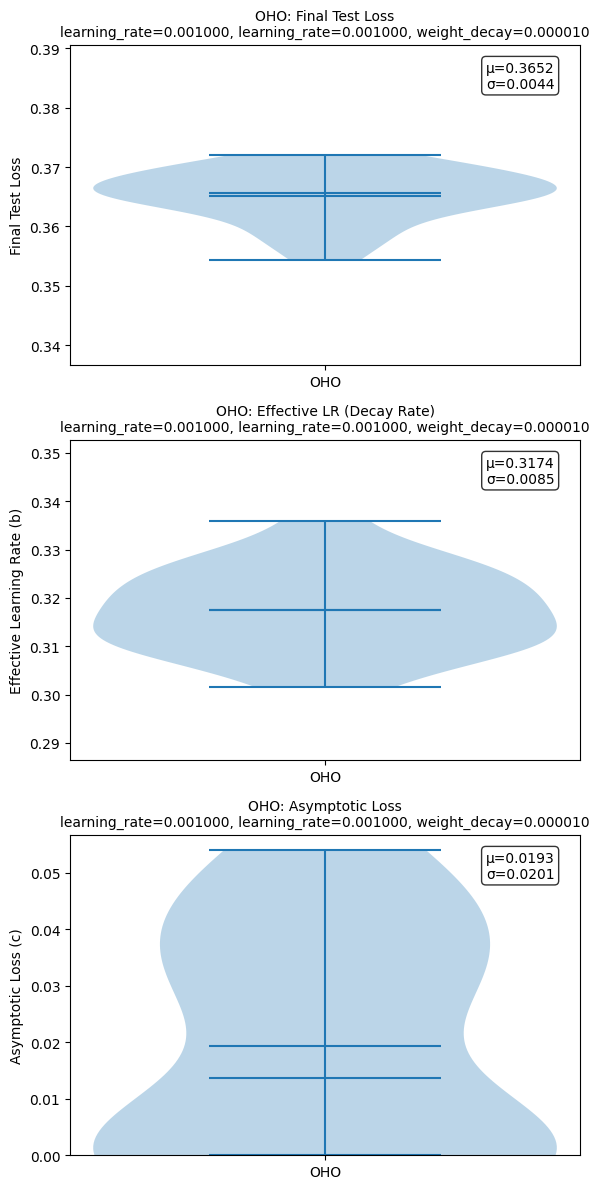

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def power_law(t, a, b, c):
    return a * (t + 1) ** (-b) + c

def plot_final_loss_and_effective_lr_violins(experiments):
    """
    Plot violin plots for final test loss and effective learning rate across experiments.
    Only uses tasks from the BEST configuration based on learning rate, meta learning rate, weight decay, and momentum.
    Memory-efficient version that processes data in chunks and uses Dask operations.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
    """
    n_experiments = len(experiments)
    
    all_final_losses = []
    all_eff_lrs = []
    all_asymptotes = []
    experiment_data = []
    
    for name, df_metadata, df_timeseries in experiments:
        print(f"\n{'='*60}")
        print(f"Processing {name}...")
        print(f"{'='*60}")
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value',
            # 'config/learners/1/optimizer/momentum'
        ]
        
        # Check which columns exist (compute only column names)
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            print(f"Warning: No configuration columns found.")
            continue
        
        print(f"Using configuration columns: {available_cols}")
        
        # Group by config and get mean final test loss using Dask
        # This aggregates across ALL seeds for each unique config
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'std', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        
        print(f"\nAll configurations ranked by mean final test loss (aggregated across seeds):")
        print("-" * 80)
        for rank, (_, row) in enumerate(config_summary.iterrows(), start=1):
            config_str = ", ".join([f"{col.split('/')[-2] if 'momentum' in col else col.split('/')[-2]}={float(row[col]):.6f}" for col in available_cols])
            print(f"Rank {rank}: {config_str} | "
                f"mean={row['mean']:.6f}, std={row['std']:.6f}, n_seeds={int(row['count'])}")
        
        # Best config is the one with LOWEST mean final test loss across all seeds
        best_config = config_summary.iloc[0]
        config_str = ", ".join([f"{col.split('/')[-2] if 'momentum' in col else col.split('/')[-2]}={float(best_config[col]):.6f}" for col in available_cols])
        
        print(f"\n{'*'*80}")
        print(f"BEST CONFIG: {config_str}")
        print(f"Mean final test loss: {best_config['mean']:.6f}")
        print(f"Number of seeds: {int(best_config['count'])}")
        print(f"{'*'*80}")
        
        # Filter metadata to best config using Dask - gets ALL tasks with this exact config (all seeds)
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id', 'metric/final_test_loss']].compute()
        
        # Get final test losses for best config (one per seed)
        final_losses = best_metadata['metric/final_test_loss'].dropna().values
        best_task_ids = best_metadata['task_id'].values
        
        print(f"\nProcessing {len(best_task_ids)} tasks (seeds) for effective learning rate...")
        
        # Compute effective learning rates and asymptotes from test loss curves for best config tasks
        # Process in chunks to avoid memory issues
        eff_lrs = []
        asymptotes = []
        chunk_size = 10
        
        for i in range(0, len(best_task_ids), chunk_size):
            chunk_ids = best_task_ids[i:i+chunk_size]
            # Filter timeseries for this chunk using Dask
            chunk_timeseries = df_timeseries[df_timeseries['task_id'].isin(chunk_ids.tolist())][['task_id', 'iteration', 'metric/test_loss']].compute()
            
            for task_id in chunk_ids:
                task_data = chunk_timeseries[chunk_timeseries['task_id'] == task_id]
                if len(task_data) > 5:
                    try:
                        iterations = task_data['iteration'].values
                        test_losses = task_data['metric/test_loss'].dropna().values
                        if len(test_losses) > 5:
                            popt, _ = curve_fit(power_law, iterations[:len(test_losses)], test_losses,
                                              bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
                            eff_lrs.append(popt[1])  # b parameter (decay rate)
                            asymptotes.append(popt[2])  # c parameter (asymptotic loss)
                    except:
                        continue
            
            print(f"  Processed {min(i+chunk_size, len(best_task_ids))}/{len(best_task_ids)} tasks")
        
        eff_lrs = np.array(eff_lrs)
        asymptotes = np.array(asymptotes)
        
        experiment_data.append({
            'name': name,
            'config': config_str,
            'final_losses': final_losses,
            'eff_lrs': eff_lrs,
            'asymptotes': asymptotes
        })
        
        all_final_losses.extend(final_losses)
        all_eff_lrs.extend(eff_lrs)
        all_asymptotes.extend(asymptotes)
        
        print(f"\nBest config statistics:")
        print(f"  Final losses: {len(final_losses)} tasks")
        print(f"  Effective LRs: {len(eff_lrs)} tasks")
        print(f"  Asymptotes: {len(asymptotes)} tasks")
    
    # Calculate shared y-axis limits
    final_loss_ylim = (min(all_final_losses) * 0.95, max(all_final_losses) * 1.05)
    eff_lr_ylim = (min(all_eff_lrs) * 0.95, max(all_eff_lrs) * 1.05)
    asymptote_ylim = (min(all_asymptotes) * 0.95, max(all_asymptotes) * 1.05)
    
    # Create plots with much more spacing
    fig, axes = plt.subplots(3, n_experiments, figsize=(6 * n_experiments, 12))
    if n_experiments == 1:
        axes = axes.reshape(3, 1)
    
    # Increase spacing significantly between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.6)
    
    for i, data in enumerate(experiment_data):
        # Final test loss
        axes[0, i].violinplot([data['final_losses']], positions=[0], showmeans=True, showmedians=True)
        mean_val, std_val = np.mean(data['final_losses']), np.std(data['final_losses'])
        axes[0, i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}', 
                       transform=axes[0, i].transAxes, va='top', ha='right',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        axes[0, i].set_title(f"{data['name']}: Final Test Loss\n{data['config']}", fontsize=10)
        axes[0, i].set_ylabel("Final Test Loss")
        axes[0, i].set_xticks([0])
        axes[0, i].set_xticklabels([data['name']])
        axes[0, i].set_ylim(final_loss_ylim)
        
        # Effective learning rate
        if len(data['eff_lrs']) > 0:
            axes[1, i].violinplot([data['eff_lrs']], positions=[0], showmeans=True, showmedians=True)
            mean_val, std_val = np.mean(data['eff_lrs']), np.std(data['eff_lrs'])
            axes[1, i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}', 
                           transform=axes[1, i].transAxes, va='top', ha='right',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            axes[1, i].set_ylim(eff_lr_ylim)
        else:
            axes[1, i].text(0.5, 0.5, "No Data", ha="center", va="center", 
                           transform=axes[1, i].transAxes)
        
        axes[1, i].set_title(f"{data['name']}: Effective LR (Decay Rate)\n{data['config']}", fontsize=10)
        axes[1, i].set_ylabel("Effective Learning Rate (b)")
        axes[1, i].set_xticks([0])
        axes[1, i].set_xticklabels([data['name']])
        
        # Asymptotic loss
        if len(data['asymptotes']) > 0:
            axes[2, i].violinplot([data['asymptotes']], positions=[0], showmeans=True, showmedians=True)
            mean_val, std_val = np.mean(data['asymptotes']), np.std(data['asymptotes'])
            axes[2, i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}', 
                           transform=axes[2, i].transAxes, va='top', ha='right',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            axes[2, i].set_ylim(asymptote_ylim)
        else:
            axes[2, i].text(0.5, 0.5, "No Data", ha="center", va="center", 
                           transform=axes[2, i].transAxes)
        
        axes[2, i].set_title(f"{data['name']}: Asymptotic Loss\n{data['config']}", fontsize=10)
        axes[2, i].set_ylabel("Asymptotic Loss (c)")
        axes[2, i].set_xticks([0])
        axes[2, i].set_xticklabels([data['name']])
    
    plt.tight_layout()
    plt.show()



plot_final_loss_and_effective_lr_violins(experiments)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Set high quality defaults
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.15
plt.rcParams['grid.linewidth'] = 0.8

def plot_loss_difference_distribution(exp1_tuple, exp2_tuple):
    name1, df_metadata1, df_timeseries1 = exp1_tuple
    name2, df_metadata2, df_timeseries2 = exp2_tuple
    
    config_cols = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/1/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    
    # Best config for exp1
    available_cols1 = [col for col in config_cols if col in df_metadata1.columns]
    config_summary1 = df_metadata1.groupby(available_cols1)['metric/final_test_loss'].agg(['mean', 'count']).compute()
    config_summary1 = config_summary1.reset_index().sort_values('mean')
    best_config1 = config_summary1.iloc[0]
    lr0_1 = float(best_config1['config/learners/0/optimizer/learning_rate/value'])
    wd_1 = float(best_config1['config/learners/0/optimizer/weight_decay/value'])
    config_str1 = f"learning_rate={lr0_1:.6f}, weight_decay={wd_1:.6f}"
    mask1 = df_metadata1[available_cols1[0]] == best_config1[available_cols1[0]]
    for col in available_cols1[1:]:
        mask1 &= (df_metadata1[col] == best_config1[col])
    best_metadata1 = df_metadata1[mask1][['task_id', 'config/seed/global_seed', 'metric/final_test_loss']].compute()
    
    # Best config for exp2
    available_cols2 = [col for col in config_cols if col in df_metadata2.columns]
    config_summary2 = df_metadata2.groupby(available_cols2)['metric/final_test_loss'].agg(['mean', 'count']).compute()
    config_summary2 = config_summary2.reset_index().sort_values('mean')
    best_config2 = config_summary2.iloc[0]
    lr0_2 = float(best_config2['config/learners/0/optimizer/learning_rate/value'])
    lr_meta_2 = float(best_config2['config/learners/1/optimizer/learning_rate/value'])
    wd_2 = float(best_config2['config/learners/0/optimizer/weight_decay/value'])
    config_str2 = f"learning_rate={lr0_2:.6f}, weight_decay={wd_2:.6f}, meta_learning_rate={lr_meta_2:.6f}"
    mask2 = df_metadata2[available_cols2[0]] == best_config2[available_cols2[0]]
    for col in available_cols2[1:]:
        mask2 &= (df_metadata2[col] == best_config2[col])
    best_metadata2 = df_metadata2[mask2][['task_id', 'config/seed/global_seed', 'metric/final_test_loss']].compute()
    
    # Compute loss differences
    seed_to_loss1 = dict(zip(best_metadata1['config/seed/global_seed'], best_metadata1['metric/final_test_loss']))
    seed_to_loss2 = dict(zip(best_metadata2['config/seed/global_seed'], best_metadata2['metric/final_test_loss']))
    common_seeds = sorted(set(seed_to_loss1.keys()) & set(seed_to_loss2.keys()))
    loss_differences = [seed_to_loss2[s] - seed_to_loss1[s] for s in common_seeds]
    
    # Stats
    mean_diff = np.mean(loss_differences)
    median_diff = np.median(loss_differences)
    percentile_2_5 = np.percentile(loss_differences, 2.5)
    percentile_97_5 = np.percentile(loss_differences, 97.5)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_facecolor('#FAFAFA')
    
    # Draw 75% range box (centered)
    # Draw 75% range box (already centered)
    box_width = 0.20
    x_center = 1.0
    ax.add_patch(Rectangle(
        (x_center - box_width/2, percentile_2_5),
        box_width,
        percentile_97_5 - percentile_2_5,
        facecolor='#4A90E2',
        alpha=0.5,
        edgecolor='#4A90E2',
        linewidth=2,
        zorder=1
    ))

    # 75% range label - moved slightly down to avoid overlapping mean line
    ax.text(
        x_center - box_width/2 - 0.01,                     # slightly left of the box
        percentile_2_5 + 0.25*(percentile_97_5 - percentile_2_5),  # 25% up from bottom of box
        "95% of points\nlie in this range",
        fontsize=11, fontweight='bold', color='#2C5282',
        va='center', ha='right',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='#4A90E2', linewidth=2, alpha=0.9)
    )




    
    # Scatter points with jitter
    np.random.seed(42)
    x_positions = np.random.normal(x_center, 0.035, len(loss_differences))
    point_colors = ['#E53E3E' if d > 0 else '#38A169' for d in loss_differences]
    ax.scatter(x_positions, loss_differences, s=50, c=point_colors, edgecolors='white', linewidth=0.5, alpha=0.6, zorder=2)
    
    # Zero line
    ax.axhline(0, color='#1A202C', linewidth=2)
    
    # Mean + median lines
    ax.axhline(mean_diff, linestyle='--', linewidth=2.5, color='#48BB78', zorder=3)
    ax.axhline(median_diff, linewidth=3, color='#E53E3E', zorder=3)
    
    # Labels for mean + median
    ax.text(x_center + 0.08, mean_diff, f'Mean: {mean_diff:.6f}', color='#48BB78',
            fontsize=11, fontweight='bold', va='center', bbox=dict(facecolor='white', alpha=0.9, edgecolor='#48BB78', linewidth=1.5))
    ax.text(x_center + 0.08, median_diff, f'Median: {median_diff:.6f}', color='#E53E3E',
            fontsize=11, fontweight='bold', va='center', bbox=dict(facecolor='white', alpha=0.9, edgecolor='#E53E3E', linewidth=1.5))
    
    # Axes labels & title
    ax.set_ylabel(f'Final Test Loss Difference\n({name2} − {name1})', fontsize=14, fontweight='bold')
    ax.set_xticks([x_center])
    ax.set_xticklabels([f'{name2} vs {name1}'], fontsize=12, fontweight='bold')
    ax.set_title(f'Distribution of Pairwise Loss Differences\n\n{name1}: {config_str1}\n{name2}: {config_str2}',
                 fontsize=14, fontweight='bold')
    
    # Summary text
    better_count = sum(1 for d in loss_differences if d < 0)
    ax.text(0.5, -0.12, f'{better_count}/{len(loss_differences)} seeds show {name2} better than {name1}',
            ha='center', transform=ax.transAxes, fontsize=12, fontweight='bold')
    
    # Tight x-limits around center
    ax.set_xlim(0.85, 1.15)
    
    plt.tight_layout()
    plt.show()
    return fig

# Example usage (FULL)
fig = plot_loss_difference_distribution(experiments[0], experiments[1])
fig.savefig('loss_difference_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')


IndexError: list index out of range


Processing OHO...
  Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']
  Best config: learning_rate=0.001000, learning_rate=0.001000, weight_decay=0.000010
  Mean final test loss: 0.365209
  Number of seeds: 20
  Averaged power law params: a=4.8153, b=0.3174, c=0.0193
  Number of tasks used: 20


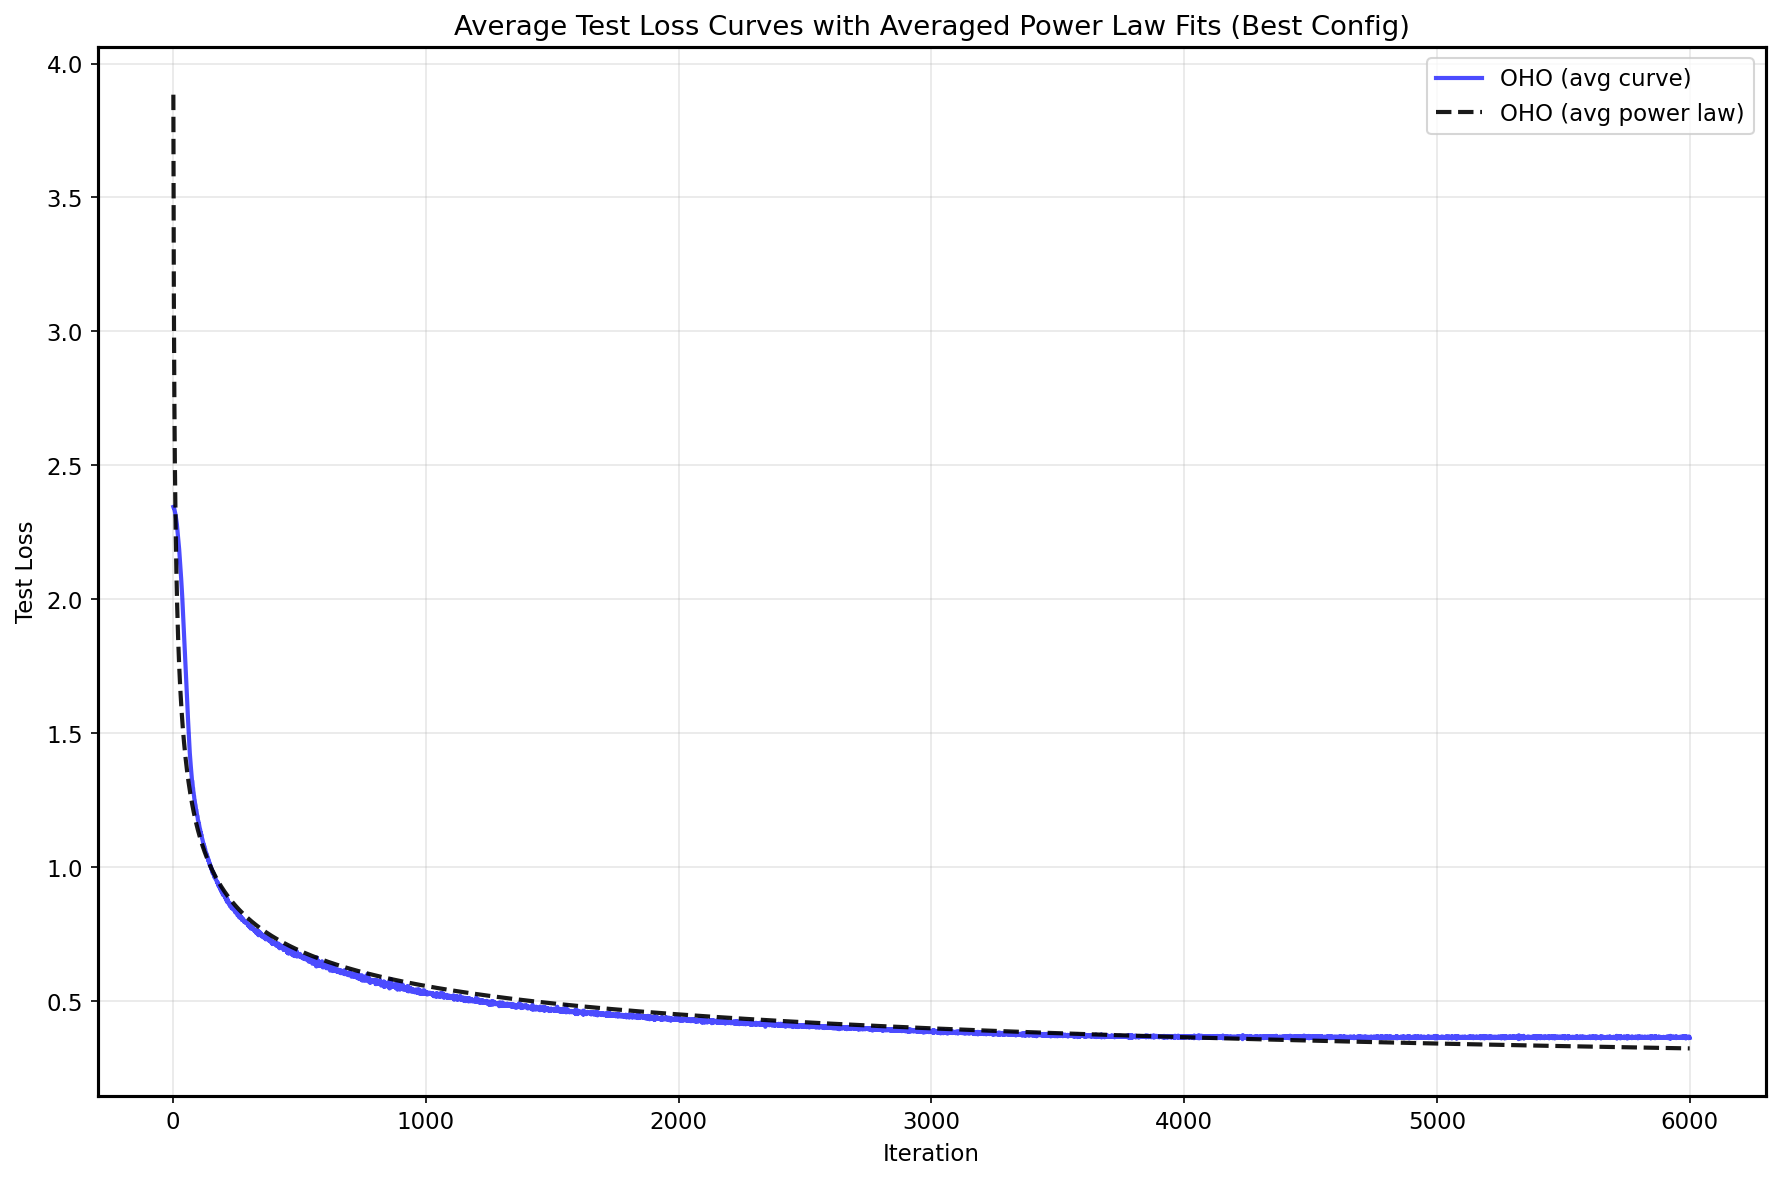

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def power_law(t, a, b, c):
    return a * (t + 1) ** (-b) + c

def plot_average_test_loss_curves_with_powerlaw(experiments):
    """
    Plot average test loss curves with averaged power law fits.
    Fits power law to each task individually, then averages the parameters.
    Uses best config based on learning rate, meta learning rate, and weight decay.
    Memory-efficient version.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    for idx, (name, df_metadata, df_timeseries) in enumerate(experiments):
        print(f"\nProcessing {name}...")
        color = colors[idx % len(colors)]
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value',
            # 'config/learners/1/optimizer/momentum',
        ]
        
        # Check which columns exist
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            print(f"Warning: No configuration columns found.")
            continue
        
        print(f"  Using configuration columns: {available_cols}")
        
        # Find best config using Dask
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]
        
        config_str = ", ".join([f"{col.split('/')[-2]}={float(best_config[col]):.6f}" for col in available_cols])
        print(f"  Best config: {config_str}")
        print(f"  Mean final test loss: {best_config['mean']:.6f}")
        print(f"  Number of seeds: {int(best_config['count'])}")
        
        # Filter to best config using Dask
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id']].compute()
        best_task_ids = best_metadata['task_id'].values
        
        # Get timeseries for best config using Dask
        best_timeseries = df_timeseries[df_timeseries['task_id'].isin(best_task_ids.tolist())][['task_id', 'iteration', 'metric/test_loss']].compute()
        
        # Compute average test loss curve
        avg_curve = best_timeseries.groupby('iteration')['metric/test_loss'].mean()
        iterations = avg_curve.index.values
        avg_test_losses = avg_curve.values
        
        # Fit power law to each individual task and collect parameters
        power_law_params = []
        chunk_size = 10
        
        for i in range(0, len(best_task_ids), chunk_size):
            chunk_ids = best_task_ids[i:i+chunk_size]
            
            for task_id in chunk_ids:
                task_data = best_timeseries[best_timeseries['task_id'] == task_id]
                if len(task_data) > 5:
                    try:
                        task_iterations = task_data['iteration'].values
                        task_losses = task_data['metric/test_loss'].dropna().values
                        if len(task_losses) > 5:
                            popt, _ = curve_fit(power_law, task_iterations[:len(task_losses)], task_losses,
                                              bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
                            power_law_params.append(popt)
                    except:
                        continue
        
        if power_law_params:
            # Average the power law parameters
            avg_a = np.mean([p[0] for p in power_law_params])
            avg_b = np.mean([p[1] for p in power_law_params])
            avg_c = np.mean([p[2] for p in power_law_params])
            
            print(f"  Averaged power law params: a={avg_a:.4f}, b={avg_b:.4f}, c={avg_c:.4f}")
            print(f"  Number of tasks used: {len(power_law_params)}")
            
            # Generate power law curve using averaged parameters
            fitted_curve = power_law(iterations, avg_a, avg_b, avg_c)
            
            # Plot both
            ax.plot(iterations, avg_test_losses, color=color, linewidth=2, alpha=0.7, 
                   label=f'{name} (avg curve)', linestyle='-')
            ax.plot(iterations, fitted_curve, color='black', linewidth=2, alpha=0.9,
                   label=f'{name} (avg power law)', linestyle='--')
        else:
            print(f"  Failed to fit power laws")
            ax.plot(iterations, avg_test_losses, color=color, linewidth=2, 
                   label=f'{name} (avg curve)')
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Test Loss')
    ax.set_title('Average Test Loss Curves with Averaged Power Law Fits (Best Config)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



plot_average_test_loss_curves_with_powerlaw(experiments)


Processing Fixed LR...

Processing OHO...

Example seed selected: 12
  Fixed LR final loss: 1.522163
  OHO final loss: 1.399299

Fixed LR power law params: a=2.9776, b=0.0739, c=0.0000
OHO power law params: a=3.5735, b=0.1019, c=0.0000


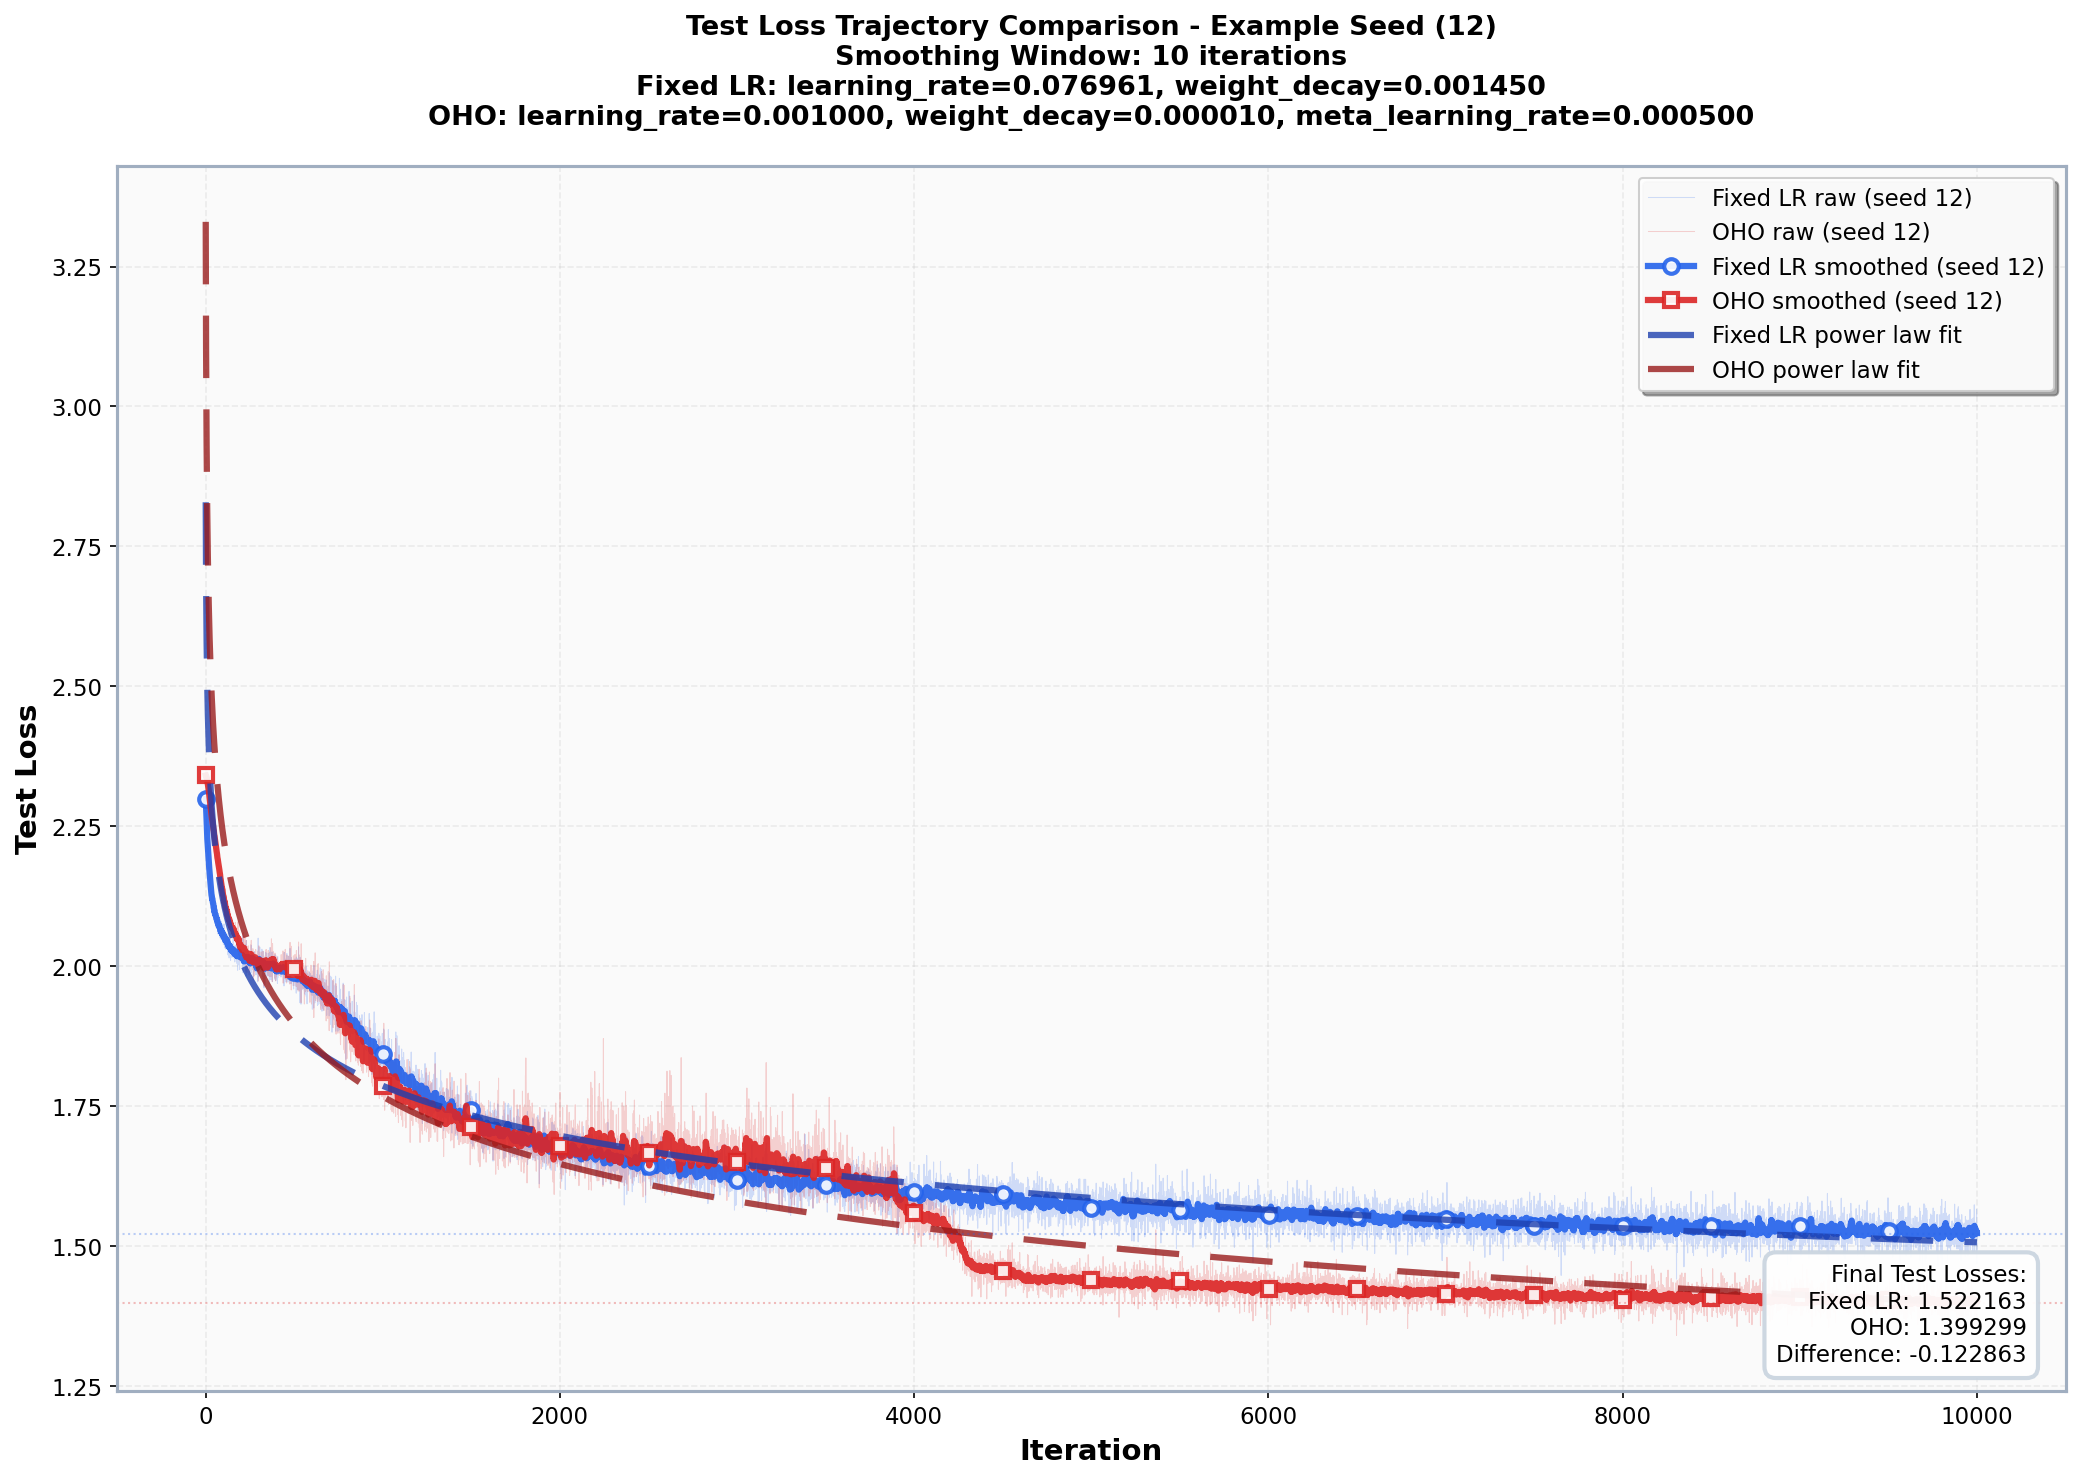

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d

def power_law(t, a, b, c):
    return a * (t + 1) ** (-b) + c

def plot_best_seed_trajectory_comparison(exp1_tuple, exp2_tuple, smoothing_window=10):
    """
    Plot test loss trajectories for an example seed (the one with lowest test loss),
    comparing both experiments on the same seed with optional smoothing.
    
    Args:
        exp1_tuple: tuple (name, df_metadata, df_timeseries) for experiment 1 (e.g., fixed LR)
        exp2_tuple: tuple (name, df_metadata, df_timeseries) for experiment 2 (e.g., OHO)
        smoothing_window: Window size for moving average smoothing (default: 10)
    """
    name1, df_metadata1, df_timeseries1 = exp1_tuple
    name2, df_metadata2, df_timeseries2 = exp2_tuple
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    print(f"\nProcessing {name1}...")
    
    # Get best config for experiment 1
    config_cols = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/1/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    
    available_cols1 = [col for col in config_cols if col in df_metadata1.columns]
    config_summary1 = df_metadata1.groupby(available_cols1)['metric/final_test_loss'].agg(['mean', 'count']).compute()
    config_summary1 = config_summary1.reset_index().sort_values('mean')
    best_config1 = config_summary1.iloc[0]
    
    # Filter to best config for exp1
    mask1 = df_metadata1[available_cols1[0]] == best_config1[available_cols1[0]]
    for col in available_cols1[1:]:
        mask1 &= (df_metadata1[col] == best_config1[col])
    best_metadata1 = df_metadata1[mask1][['task_id', 'config/seed/global_seed', 'metric/final_test_loss']].compute()
    
    print(f"\nProcessing {name2}...")
    
    # Get best config for experiment 2
    available_cols2 = [col for col in config_cols if col in df_metadata2.columns]
    config_summary2 = df_metadata2.groupby(available_cols2)['metric/final_test_loss'].agg(['mean', 'count']).compute()
    config_summary2 = config_summary2.reset_index().sort_values('mean')
    best_config2 = config_summary2.iloc[0]
    
    # Filter to best config for exp2
    mask2 = df_metadata2[available_cols2[0]] == best_config2[available_cols2[0]]
    for col in available_cols2[1:]:
        mask2 &= (df_metadata2[col] == best_config2[col])
    best_metadata2 = df_metadata2[mask2][['task_id', 'config/seed/global_seed', 'metric/final_test_loss']].compute()
    
    # Find common seeds
    seed_to_loss1 = dict(zip(best_metadata1['config/seed/global_seed'], best_metadata1['metric/final_test_loss']))
    seed_to_loss2 = dict(zip(best_metadata2['config/seed/global_seed'], best_metadata2['metric/final_test_loss']))
    seed_to_task1 = dict(zip(best_metadata1['config/seed/global_seed'], best_metadata1['task_id']))
    seed_to_task2 = dict(zip(best_metadata2['config/seed/global_seed'], best_metadata2['task_id']))
    
    common_seeds = set(seed_to_loss1.keys()) & set(seed_to_loss2.keys())
    
    if len(common_seeds) == 0:
        print("No common seeds found!")
        return
    
    # Find the seed with lowest test loss (considering both experiments)
    example_seed = None
    best_loss = float('inf')
    
    for seed in common_seeds:
        # Use the minimum of the two losses to find the overall best performing seed
        min_loss = min(seed_to_loss1[seed], seed_to_loss2[seed])
        if min_loss < best_loss:
            best_loss = min_loss
            example_seed = seed
    
    print(f"\nExample seed selected: {int(example_seed)}")
    print(f"  {name1} final loss: {seed_to_loss1[example_seed]:.6f}")
    print(f"  {name2} final loss: {seed_to_loss2[example_seed]:.6f}")
    
    # Get task IDs for the example seed
    task_id1 = seed_to_task1[example_seed]
    task_id2 = seed_to_task2[example_seed]
    
    # Get timeseries data for both experiments on this seed
    timeseries1 = df_timeseries1[df_timeseries1['task_id'] == task_id1][
        ['iteration', 'metric/test_loss']
    ].compute()
    
    timeseries2 = df_timeseries2[df_timeseries2['task_id'] == task_id2][
        ['iteration', 'metric/test_loss']
    ].compute()
    
    # Sort by iteration
    timeseries1 = timeseries1.sort_values('iteration')
    timeseries2 = timeseries2.sort_values('iteration')
    
    iterations1 = timeseries1['iteration'].values
    test_losses1 = timeseries1['metric/test_loss'].values
    
    iterations2 = timeseries2['iteration'].values
    test_losses2 = timeseries2['metric/test_loss'].values
    
    # Apply smoothing
    if smoothing_window > 1:
        # Use uniform filter for moving average
        smoothed_losses1 = uniform_filter1d(test_losses1, size=smoothing_window, mode='nearest')
        smoothed_losses2 = uniform_filter1d(test_losses2, size=smoothing_window, mode='nearest')
    else:
        smoothed_losses1 = test_losses1
        smoothed_losses2 = test_losses2
    
    # Plot raw trajectories with low alpha
    ax.plot(iterations1, test_losses1, 
            color='#2563eb', linewidth=0.5, alpha=0.2, 
            linestyle='-', label=f'{name1} raw (seed {int(example_seed)})')
    
    ax.plot(iterations2, test_losses2, 
            color='#dc2626', linewidth=0.5, alpha=0.2,
            linestyle='-', label=f'{name2} raw (seed {int(example_seed)})')
    
    # Plot smoothed trajectories
    line1 = ax.plot(iterations1, smoothed_losses1, 
                    color='#2563eb', linewidth=3, alpha=0.9, 
                    label=f'{name1} smoothed (seed {int(example_seed)})', 
                    linestyle='-', marker='o', markevery=len(iterations1)//20, 
                    markersize=7, markerfacecolor='white', markeredgewidth=2)
    
    line2 = ax.plot(iterations2, smoothed_losses2, 
                    color='#dc2626', linewidth=3, alpha=0.9,
                    label=f'{name2} smoothed (seed {int(example_seed)})', 
                    linestyle='-', marker='s', markevery=len(iterations2)//20,
                    markersize=7, markerfacecolor='white', markeredgewidth=2)
    
    # Try to fit power law curves with more prominent styling
    try:
        if len(test_losses1) > 5:
            popt1, _ = curve_fit(power_law, iterations1, test_losses1,
                                bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
            fitted1 = power_law(iterations1, *popt1)
            ax.plot(iterations1, fitted1, 
                   color='#1e40af', linewidth=3, alpha=0.8,
                   linestyle='--', label=f'{name1} power law fit',
                   dashes=(10, 5))  # Custom dash pattern
            print(f"\n{name1} power law params: a={popt1[0]:.4f}, b={popt1[1]:.4f}, c={popt1[2]:.4f}")
    except:
        print(f"Failed to fit power law for {name1}")
    
    try:
        if len(test_losses2) > 5:
            popt2, _ = curve_fit(power_law, iterations2, test_losses2,
                                bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
            fitted2 = power_law(iterations2, *popt2)
            ax.plot(iterations2, fitted2, 
                   color='#991b1b', linewidth=3, alpha=0.8,
                   linestyle='--', label=f'{name2} power law fit',
                   dashes=(10, 5))  # Custom dash pattern
            print(f"{name2} power law params: a={popt2[0]:.4f}, b={popt2[1]:.4f}, c={popt2[2]:.4f}")
    except:
        print(f"Failed to fit power law for {name2}")
    
    # Format config strings for display
    lr0_1 = float(best_config1['config/learners/0/optimizer/learning_rate/value'])
    wd_1 = float(best_config1['config/learners/0/optimizer/weight_decay/value'])
    config_str1 = f"learning_rate={lr0_1:.6f}, weight_decay={wd_1:.6f}"
    
    lr0_2 = float(best_config2['config/learners/0/optimizer/learning_rate/value'])
    lr_meta_2 = float(best_config2['config/learners/1/optimizer/learning_rate/value'])
    wd_2 = float(best_config2['config/learners/0/optimizer/weight_decay/value'])
    config_str2 = f"learning_rate={lr0_2:.6f}, weight_decay={wd_2:.6f}, meta_learning_rate={lr_meta_2:.6f}"
    
    # Title and labels
    ax.set_xlabel('Iteration', fontsize=14, fontweight='bold')
    ax.set_ylabel('Test Loss', fontsize=14, fontweight='bold')
    
    title_text = (f'Test Loss Trajectory Comparison - Example Seed ({int(example_seed)})\n'
                  f'Smoothing Window: {smoothing_window} iterations\n'
                  f'{name1}: {config_str1}\n'
                  f'{name2}: {config_str2}')
    ax.set_title(title_text, fontsize=13, fontweight='bold', pad=20)
    
    # Add grid and styling
    ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.8)
    ax.set_facecolor('#FAFAFA')
    ax.set_axisbelow(True)
    
    # Add final loss annotations
    ax.axhline(y=seed_to_loss1[example_seed], color='#2563eb', linestyle=':', alpha=0.3, linewidth=1)
    ax.axhline(y=seed_to_loss2[example_seed], color='#dc2626', linestyle=':', alpha=0.3, linewidth=1)
    
    # Add text box with final losses
    final_loss_text = (f'Final Test Losses:\n'
                      f'{name1}: {seed_to_loss1[example_seed]:.6f}\n'
                      f'{name2}: {seed_to_loss2[example_seed]:.6f}\n'
                      f'Difference: {seed_to_loss2[example_seed] - seed_to_loss1[example_seed]:.6f}')
    
    ax.text(0.98, 0.02, final_loss_text, transform=ax.transAxes,
           fontsize=11, ha='right', va='bottom',
           bbox=dict(boxstyle='round,pad=0.5', 
                   facecolor='white', alpha=0.95,
                   edgecolor='#CBD5E0', linewidth=2))
    
    # Legend
    ax.legend(loc='upper right', frameon=True, fancybox=True, 
             shadow=True, framealpha=0.95, fontsize=11)
    
    # Enhance spine styling
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color('#A0AEC0')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Example usage:
fig = plot_best_seed_trajectory_comparison(experiments[0], experiments[1], smoothing_window=10)
fig.savefig('best_seed_trajectory_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')


Processing OHO...
  Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']
  Best config: learning_rate=0.001000, learning_rate=0.001000, weight_decay=0.000010
  Number of seeds: 20


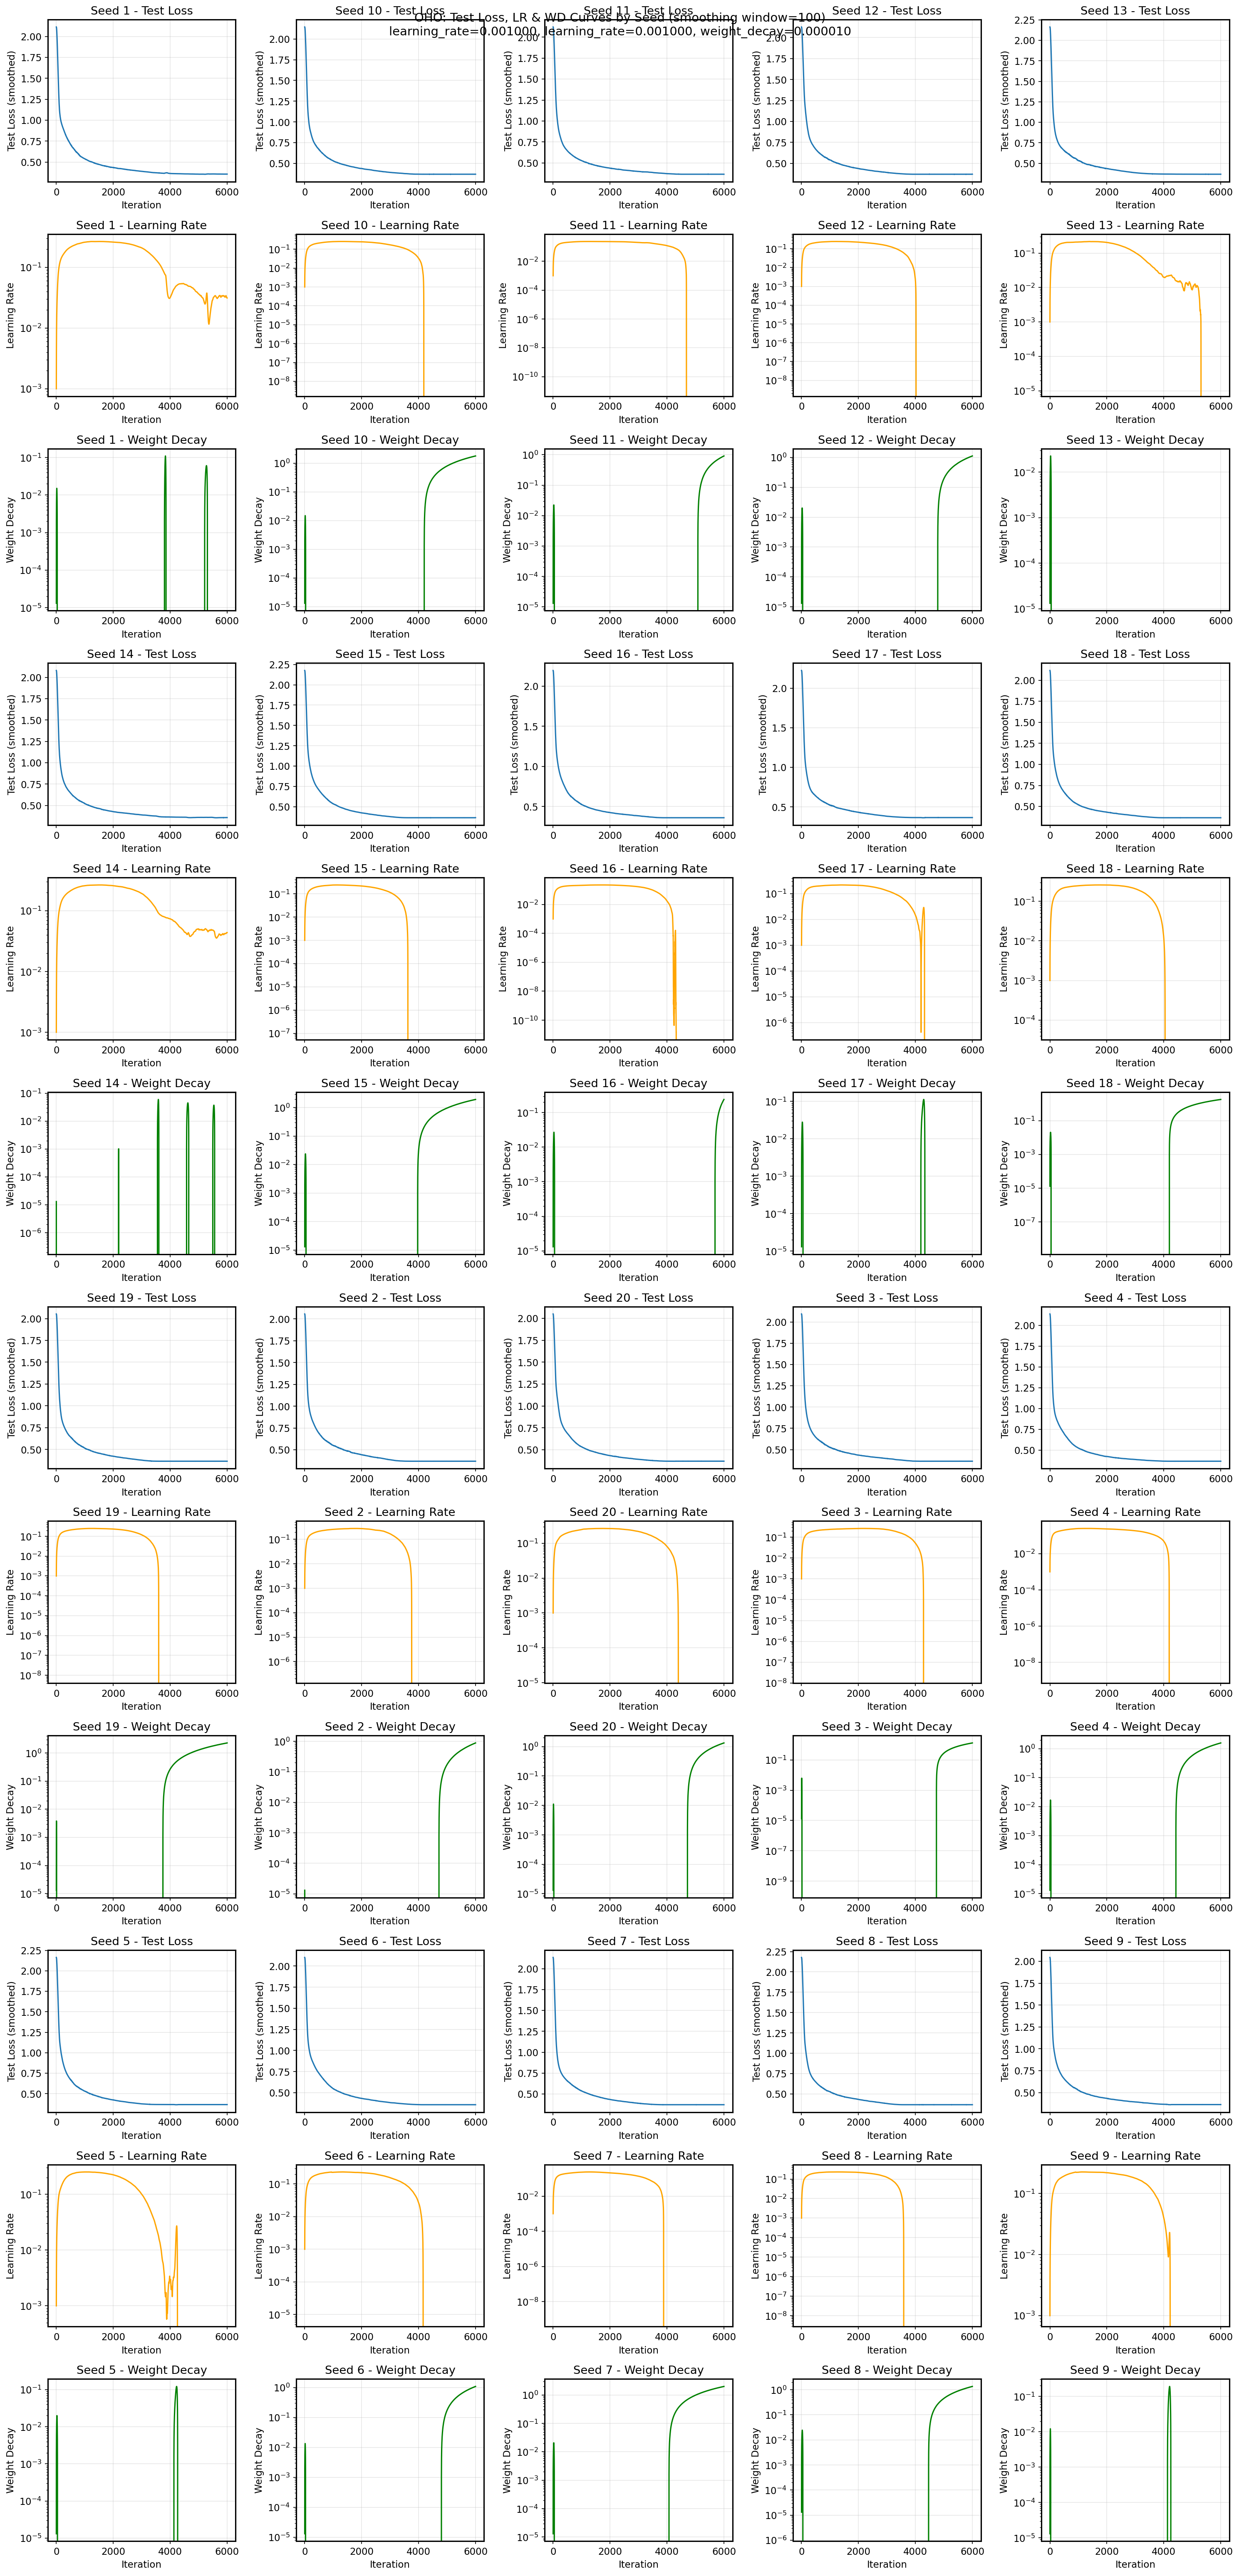

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

def plot_test_loss_and_lr_curves_by_seed(experiments, smooth_window=100):
    """
    Plot smoothed test loss curves, learning rate curves, and weight decay curves for each seed individually.
    Uses best config based on learning rate, meta learning rate, and weight decay.
    Memory-efficient version.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
        smooth_window: window size for smoothing
    """
    for name, df_metadata, df_timeseries in experiments:
        print(f"\nProcessing {name}...")
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value',
            # 'config/learners/1/optimizer/momentum'
        ]
        
        # Check which columns exist
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            print(f"Warning: No configuration columns found.")
            continue
        
        print(f"  Using configuration columns: {available_cols}")
        
        # Find best config using Dask
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]
        
        config_str = ", ".join([f"{col.split('/')[-2]}={float(best_config[col]):.6f}" for col in available_cols])
        print(f"  Best config: {config_str}")
        
        # Filter to best config using Dask
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id', 'config/seed/global_seed']].compute()
        
        # Get timeseries for best config using Dask
        best_task_ids = best_metadata['task_id'].values
        best_timeseries = df_timeseries[df_timeseries['task_id'].isin(best_task_ids.tolist())][
            ['task_id', 'iteration', 'metric/test_loss', 'metric/train_recurrent_learning_rate', 'metric/train_recurrent_weight_decay']
        ].compute()
        
        # Merge with metadata to get seeds
        best_timeseries_with_seed = best_timeseries.merge(
            best_metadata[['task_id', 'config/seed/global_seed']], 
            on='task_id'
        )
        
        # Get unique seeds
        seeds = sorted(best_timeseries_with_seed['config/seed/global_seed'].unique())
        print(f"  Number of seeds: {len(seeds)}")
        
        # Create subplots - 3 rows (test loss + LR + weight decay) per seed
        n_seeds = len(seeds)
        n_cols = 5
        n_rows = ((n_seeds + n_cols - 1) // n_cols) * 3  # 3 rows per seed group
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows))
        axes = axes.reshape(n_rows, n_cols)
        
        # Plot test loss, LR, and weight decay curve for each seed
        for idx, seed in enumerate(seeds):
            col = idx % n_cols
            row_base = (idx // n_cols) * 3
            
            seed_data = best_timeseries_with_seed[
                best_timeseries_with_seed['config/seed/global_seed'] == seed
            ].sort_values('iteration')
            
            iterations = seed_data['iteration'].values
            test_losses = seed_data['metric/test_loss'].values
            
            # Smooth test loss
            smoothed_test_losses = uniform_filter1d(test_losses, size=smooth_window)
            
            # Plot test loss
            axes[row_base, col].plot(iterations, smoothed_test_losses, linewidth=1.5)
            axes[row_base, col].set_xlabel('Iteration')
            axes[row_base, col].set_ylabel('Test Loss (smoothed)')
            axes[row_base, col].set_title(f'Seed {int(seed)} - Test Loss')
            axes[row_base, col].grid(True, alpha=0.3)
            
            # Plot learning rate
            if 'metric/train_recurrent_learning_rate' in seed_data.columns:
                learning_rates = seed_data['metric/train_recurrent_learning_rate'].values
                axes[row_base + 1, col].plot(iterations, learning_rates, linewidth=1.5, color='orange')
                axes[row_base + 1, col].set_xlabel('Iteration')
                axes[row_base + 1, col].set_ylabel('Learning Rate')
                axes[row_base + 1, col].set_title(f'Seed {int(seed)} - Learning Rate')
                axes[row_base + 1, col].grid(True, alpha=0.3)
                axes[row_base + 1, col].set_yscale('log')
            else:
                axes[row_base + 1, col].text(0.5, 0.5, 'No LR data', 
                                            ha='center', va='center',
                                            transform=axes[row_base + 1, col].transAxes)
                axes[row_base + 1, col].set_title(f'Seed {int(seed)} - Learning Rate')
            
            # Plot weight decay
            if 'metric/train_recurrent_weight_decay' in seed_data.columns:
                weight_decays = seed_data['metric/train_recurrent_weight_decay'].values
                axes[row_base + 2, col].plot(iterations, weight_decays, linewidth=1.5, color='green')
                axes[row_base + 2, col].set_xlabel('Iteration')
                axes[row_base + 2, col].set_ylabel('Weight Decay')
                axes[row_base + 2, col].set_title(f'Seed {int(seed)} - Weight Decay')
                axes[row_base + 2, col].grid(True, alpha=0.3)
                axes[row_base + 2, col].set_yscale('log')
            else:
                axes[row_base + 2, col].text(0.5, 0.5, 'No WD data', 
                                            ha='center', va='center',
                                            transform=axes[row_base + 2, col].transAxes)
                axes[row_base + 2, col].set_title(f'Seed {int(seed)} - Weight Decay')
        
        # Hide unused subplots
        total_used = ((n_seeds + n_cols - 1) // n_cols) * 3
        for row in range(total_used, n_rows):
            for col in range(n_cols):
                axes[row, col].axis('off')
        
        # Hide unused columns in last row group
        last_group_start = (len(seeds) // n_cols) * 3
        used_in_last_group = len(seeds) % n_cols
        if used_in_last_group > 0:
            for col in range(used_in_last_group, n_cols):
                axes[last_group_start, col].axis('off')
                axes[last_group_start + 1, col].axis('off')
                axes[last_group_start + 2, col].axis('off')
        
        fig.suptitle(f'{name}: Test Loss, LR & WD Curves by Seed (smoothing window={smooth_window})\n{config_str}', 
                    fontsize=14)
        plt.tight_layout()
        plt.show()


plot_test_loss_and_lr_curves_by_seed(experiments, smooth_window=100)


Processing OHO...
  Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']
  Best config: learning_rate=0.001000, learning_rate=0.001000, weight_decay=0.000010
  Number of seeds: 20


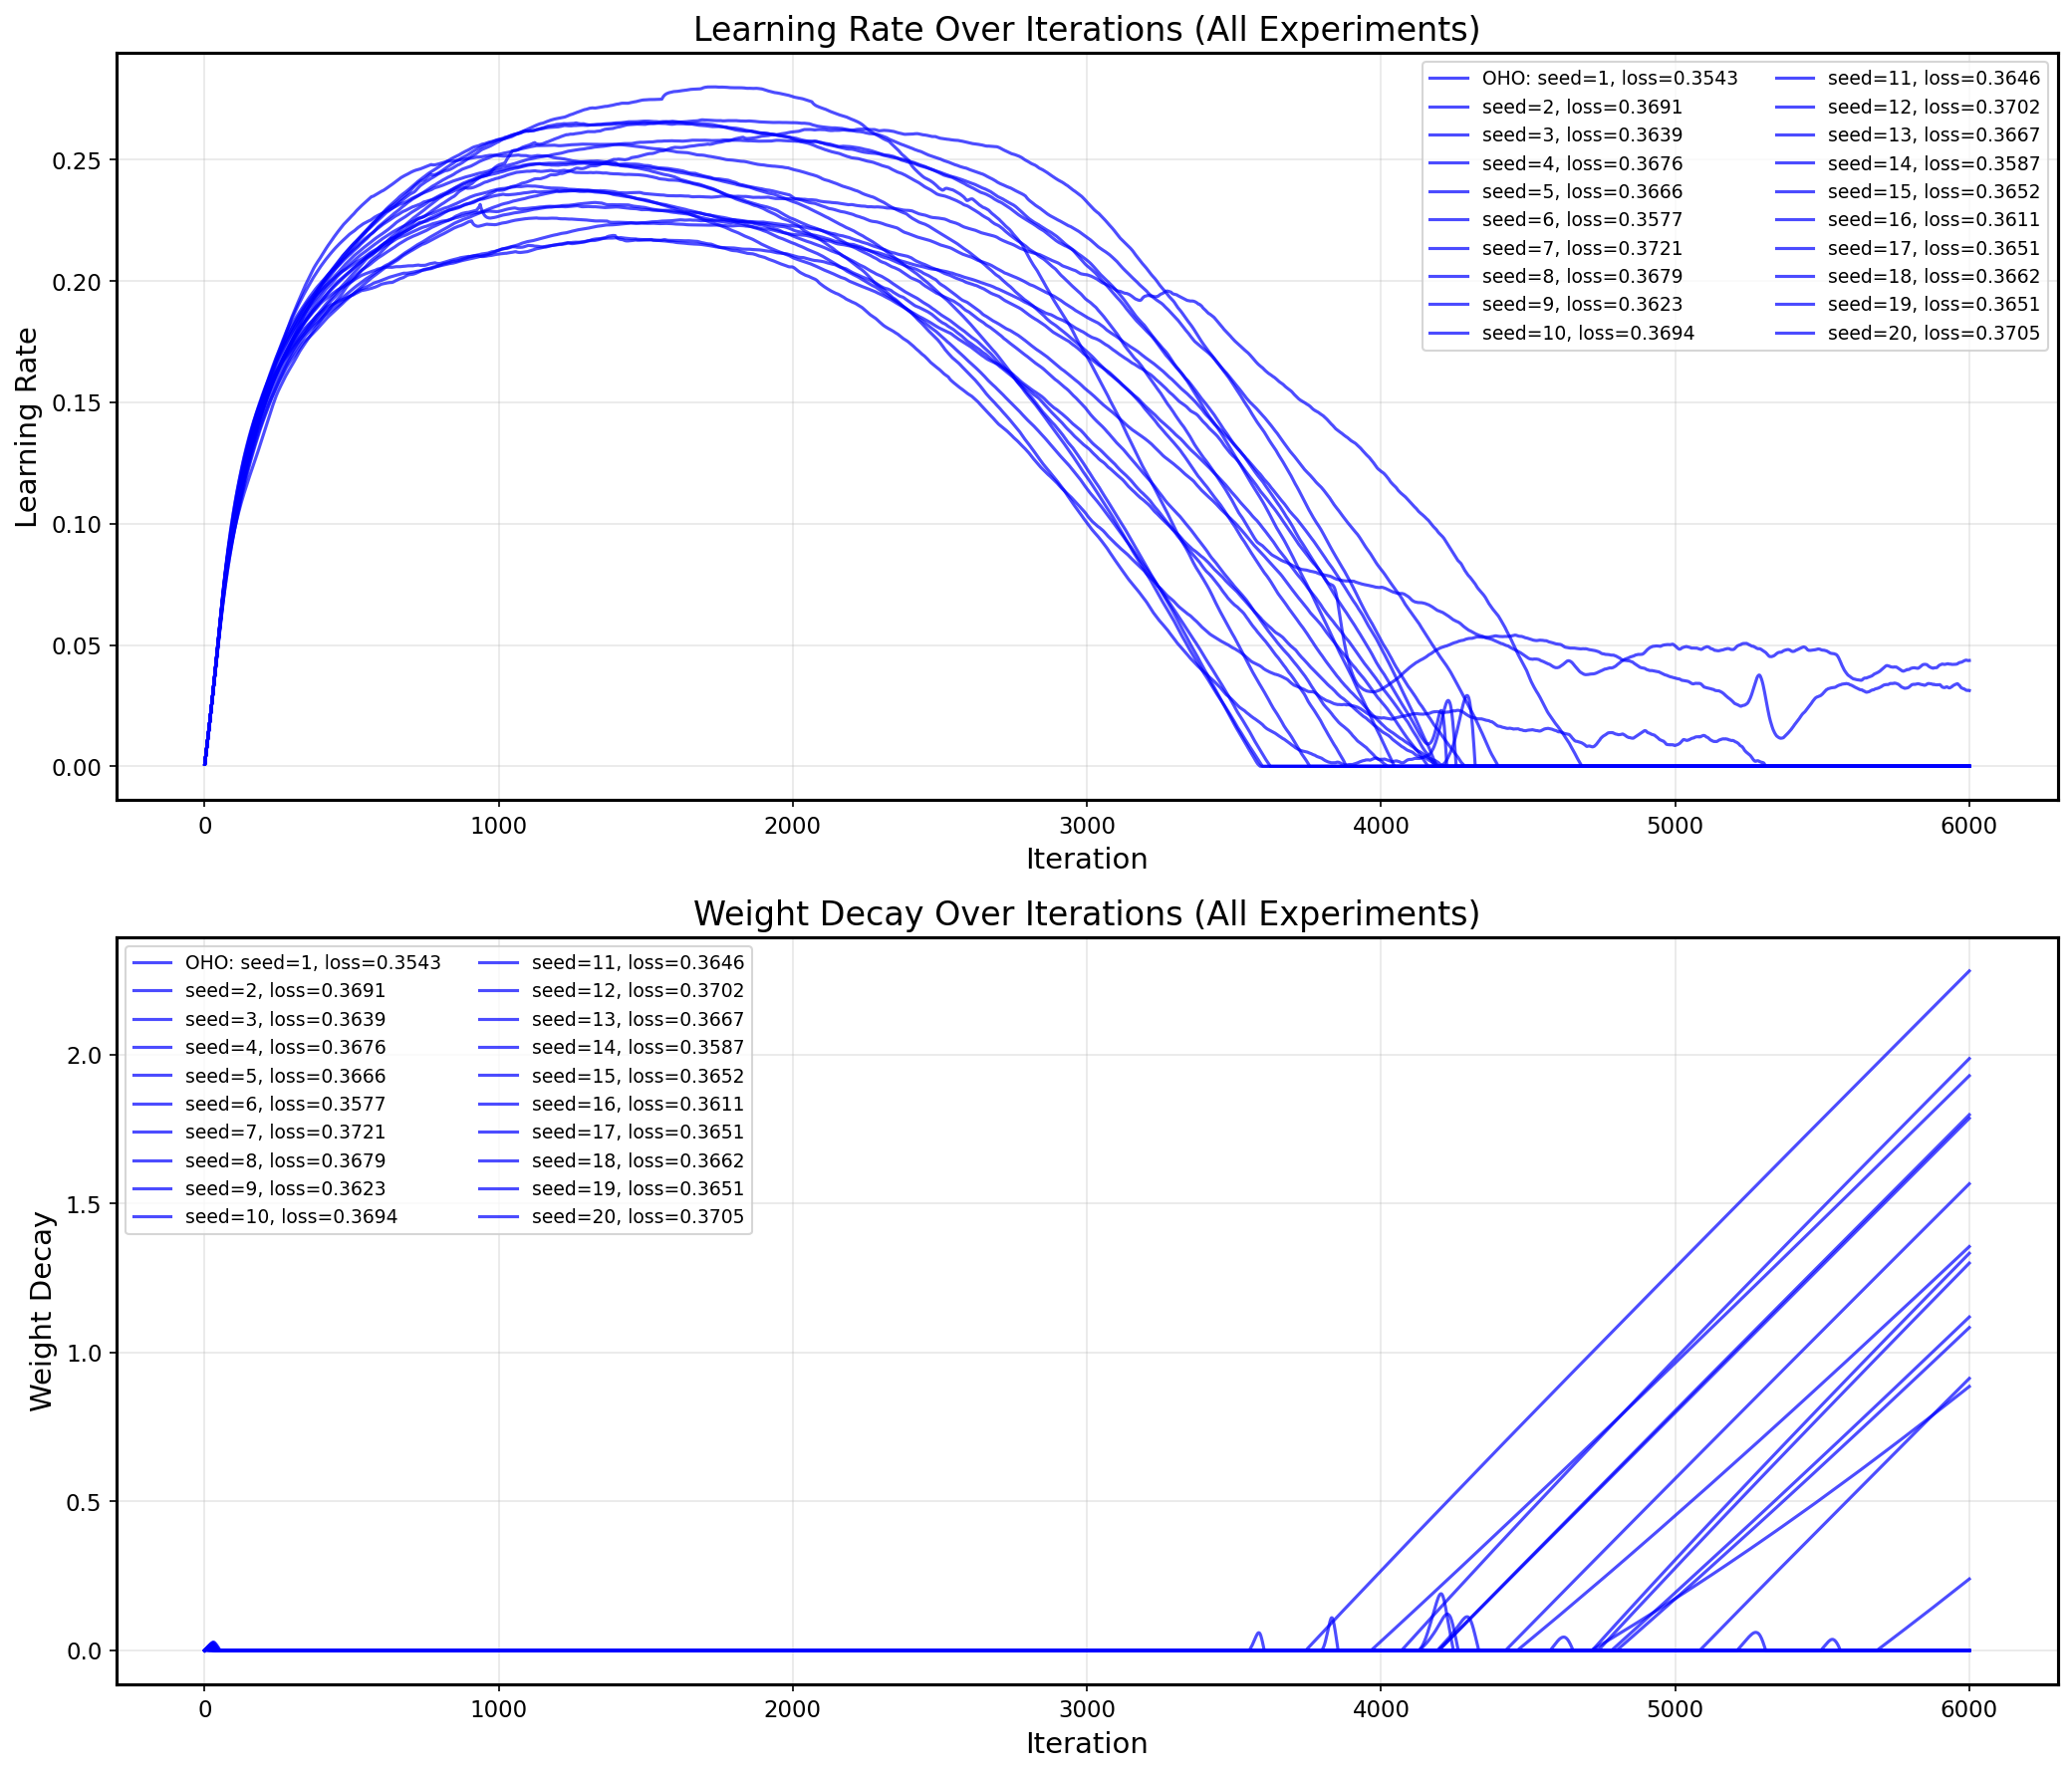

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hyperparameters_for_best_config(experiments):
    """
    Plot learning rates and weight decays over iterations for the best configuration.
    All experiments on same plots with distinct colors and labels.
    Uses best config based on learning rate, meta learning rate, and weight decay.
    Memory-efficient version.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # Create distinct colormap for experiments
    exp_colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
    
    for exp_idx, (name, df_metadata, df_timeseries) in enumerate(experiments):
        print(f"\nProcessing {name}...")
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value',
            # 'config/learners/1/optimizer/momentum'
        ]
        
        # Check which columns exist
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            print(f"Warning: No configuration columns found.")
            continue
        
        print(f"  Using configuration columns: {available_cols}")
        
        # Find best config using Dask
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]
        
        config_str = ", ".join([f"{col.split('/')[-2]}={float(best_config[col]):.6f}" for col in available_cols])
        print(f"  Best config: {config_str}")
        print(f"  Number of seeds: {int(best_config['count'])}")
        
        # Filter to best config using Dask
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id', 'config/seed/global_seed', 'metric/final_test_loss']].compute()
        
        # Get timeseries for best config tasks
        best_task_ids = best_metadata['task_id'].values
        best_timeseries = df_timeseries[df_timeseries['task_id'].isin(best_task_ids.tolist())][
            ['task_id', 'iteration', 'metric/train_recurrent_learning_rate', 'metric/train_recurrent_weight_decay']
        ].compute()
        
        exp_color = exp_colors[exp_idx % len(exp_colors)]
        
        # Plot learning rates and weight decays for each seed
        for seed_idx, (_, row) in enumerate(best_metadata.iterrows()):
            task_id = row['task_id']
            seed = row['config/seed/global_seed']
            final_loss = row['metric/final_test_loss']
            
            task_data = best_timeseries[best_timeseries['task_id'] == task_id].sort_values('iteration')
            
            if len(task_data) > 0:
                iterations = task_data['iteration'].values
                
                # Only show experiment name in label for first seed, then just seed info
                if seed_idx == 0:
                    label_prefix = f"{name}: "
                else:
                    label_prefix = ""
                
                label = f'{label_prefix}seed={seed}, loss={final_loss:.4f}'
                
                # Learning rate
                if 'metric/train_recurrent_learning_rate' in task_data.columns:
                    lrs = task_data['metric/train_recurrent_learning_rate'].values
                    axes[0].plot(iterations, lrs, alpha=0.7, linewidth=1.5, 
                               label=label, color=exp_color)
                
                # Weight decay
                if 'metric/train_recurrent_weight_decay' in task_data.columns:
                    wds = task_data['metric/train_recurrent_weight_decay'].values
                    axes[1].plot(iterations, wds, alpha=0.7, linewidth=1.5, 
                               label=label, color=exp_color)
    
    # Format learning rate plot
    axes[0].set_title("Learning Rate Over Iterations (All Experiments)", fontsize=16)
    axes[0].set_xlabel("Iteration", fontsize=14)
    axes[0].set_ylabel("Learning Rate", fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(fontsize=9, loc='best', ncol=2)
    
    # Format weight decay plot
    axes[1].set_title("Weight Decay Over Iterations (All Experiments)", fontsize=16)
    axes[1].set_xlabel("Iteration", fontsize=14)
    axes[1].set_ylabel("Weight Decay", fontsize=14)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(fontsize=9, loc='best', ncol=2)
    
    plt.tight_layout()
    plt.show()

plot_hyperparameters_for_best_config(experiments)


Processing OHO...
  Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']
  Best config: learning_rate=0.001000, learning_rate=0.001000, weight_decay=0.000010
  Number of seeds: 20


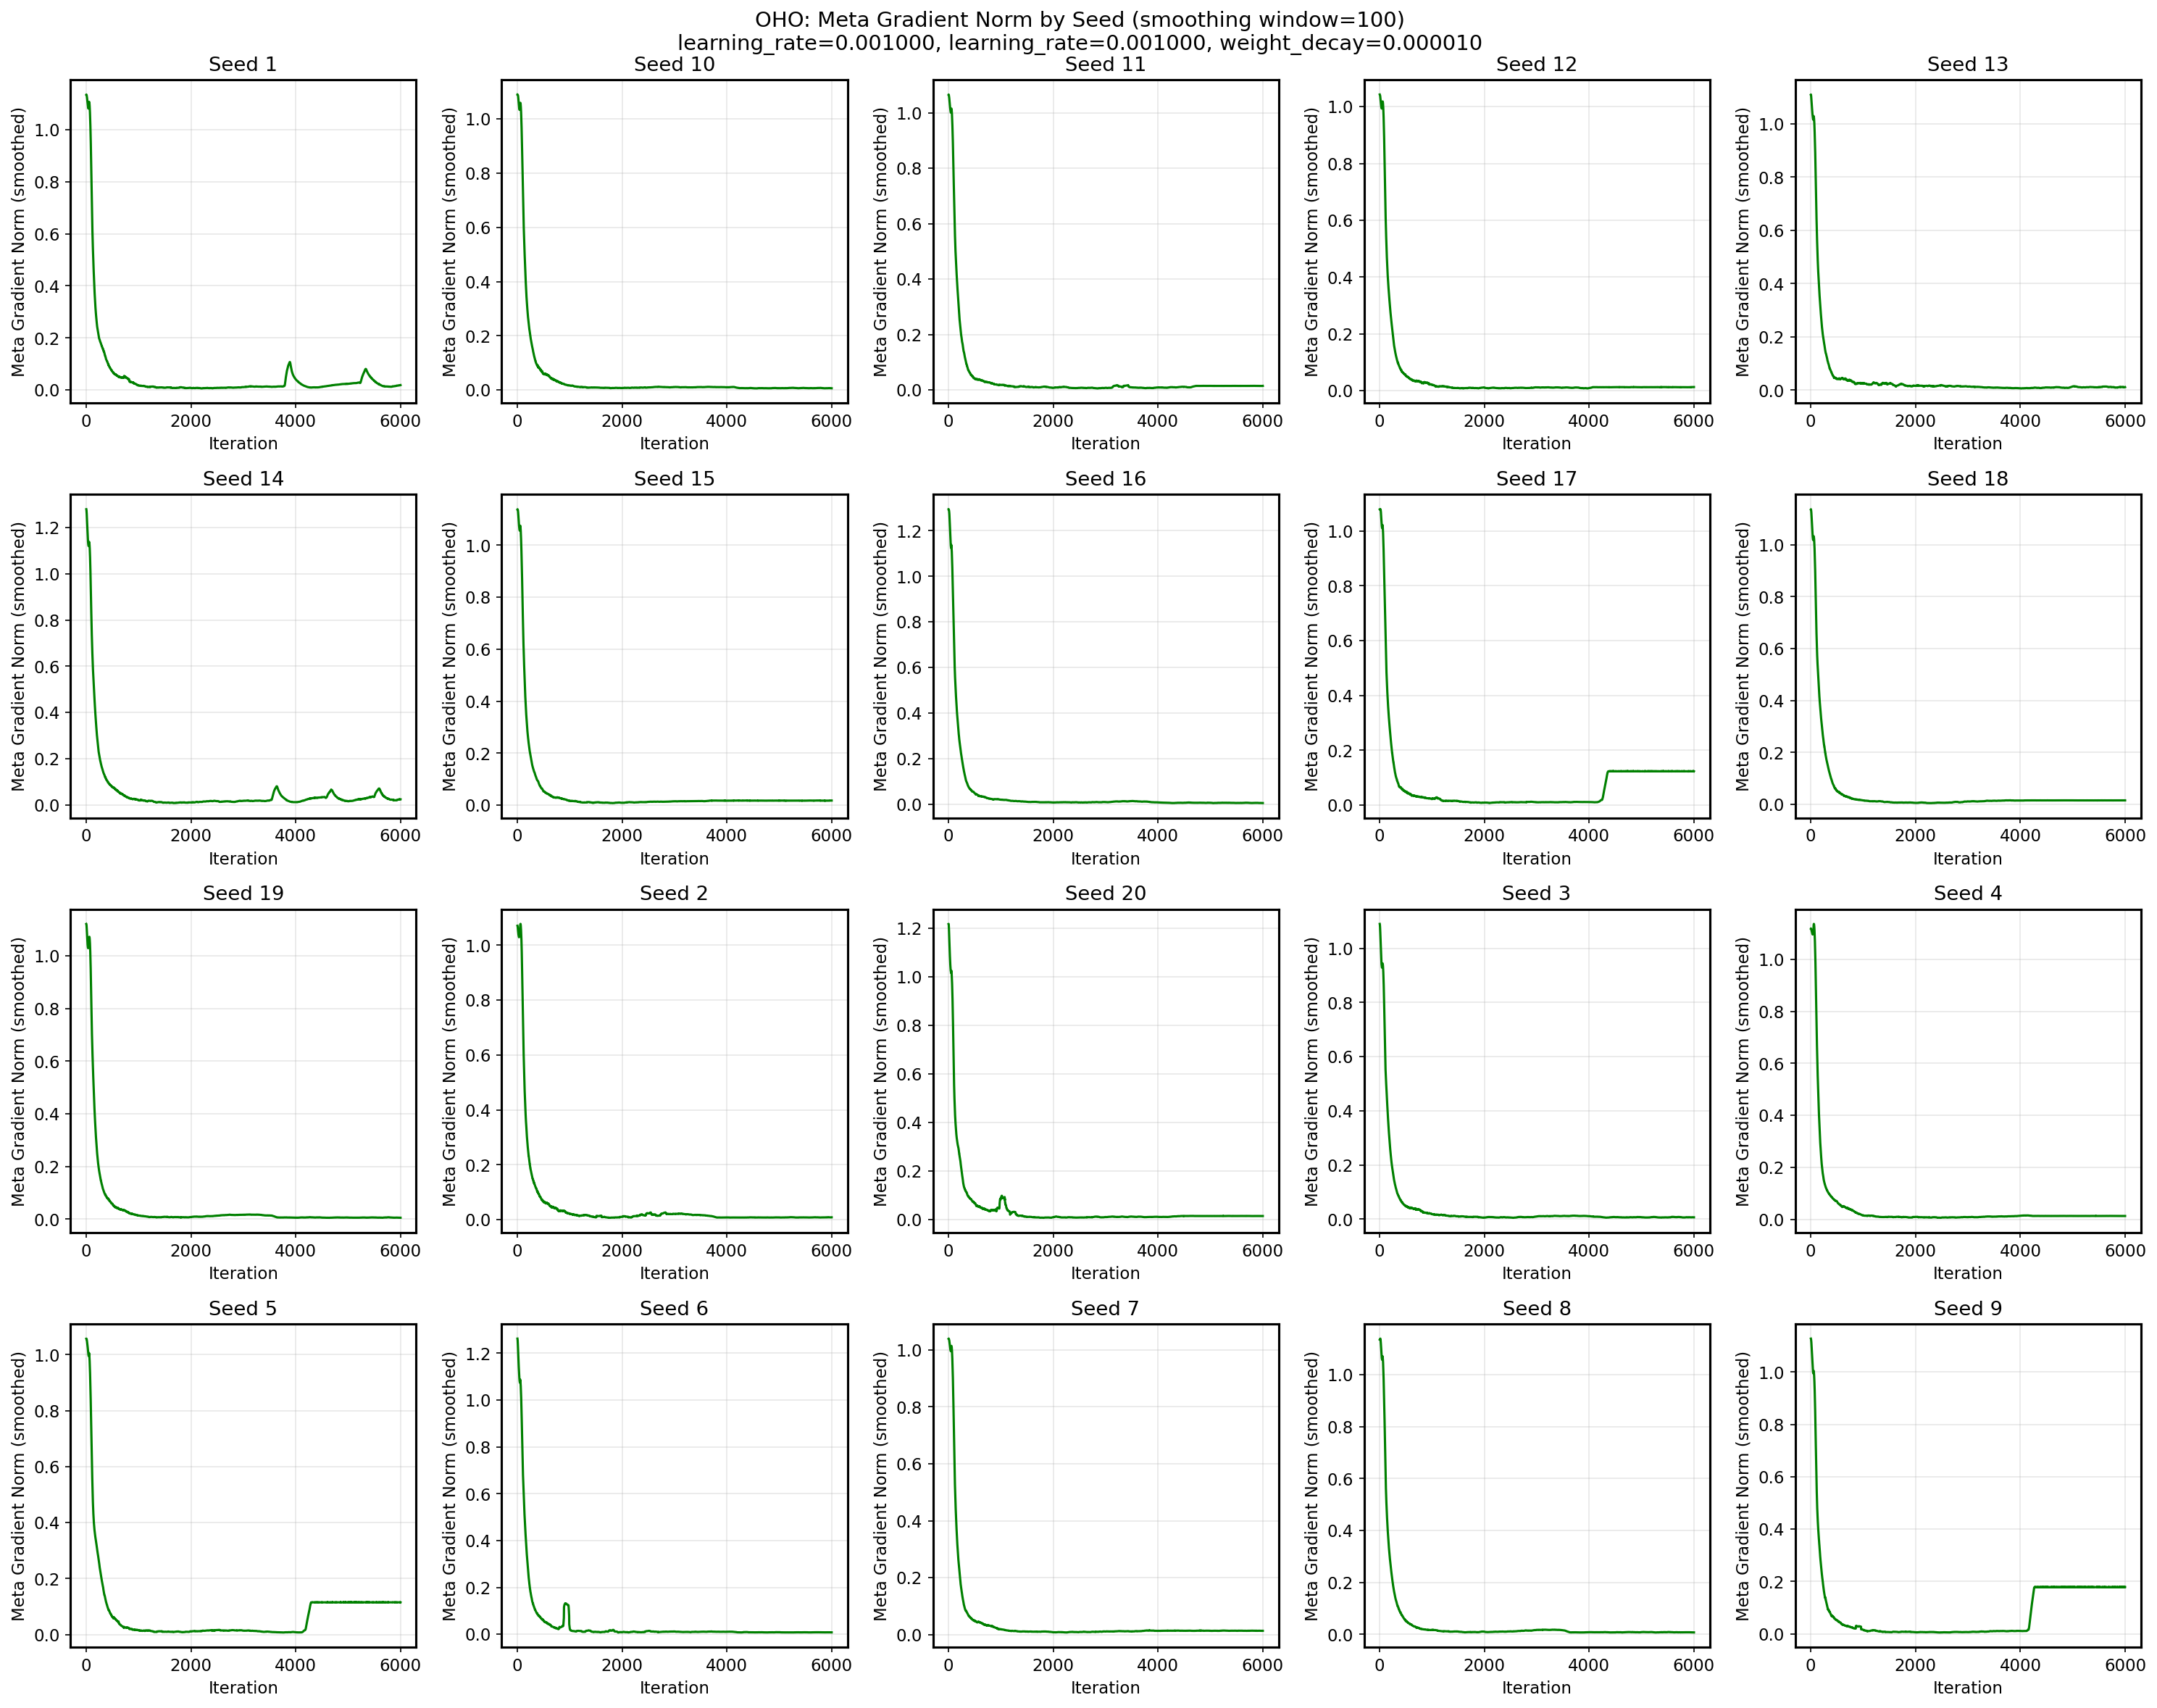

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

def plot_meta_gradient_norm_by_seed(experiments, smooth_window=None):
    """
    Plot meta gradient norm curves for each seed individually.
    Uses best config based on learning rate, meta learning rate, and weight decay.
    Memory-efficient version.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
        smooth_window: window size for smoothing, None for no smoothing
    """
    for name, df_metadata, df_timeseries in experiments:
        print(f"\nProcessing {name}...")
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value'
        ]
        
        # Check which columns exist
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            print(f"Warning: No configuration columns found.")
            continue
        
        print(f"  Using configuration columns: {available_cols}")
        
        # Find best config using Dask
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]
        
        config_str = ", ".join([f"{col.split('/')[-2]}={float(best_config[col]):.6f}" for col in available_cols])
        print(f"  Best config: {config_str}")
        
        # Filter to best config using Dask
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id', 'config/seed/global_seed']].compute()
        
        # Get timeseries for best config using Dask
        best_task_ids = best_metadata['task_id'].values
        best_timeseries = df_timeseries[df_timeseries['task_id'].isin(best_task_ids.tolist())][
            ['task_id', 'iteration', 'metric/meta_gradient_norm']
        ].compute()
        
        # Merge with metadata to get seeds
        best_timeseries_with_seed = best_timeseries.merge(
            best_metadata[['task_id', 'config/seed/global_seed']], 
            on='task_id'
        )
        
        # Get unique seeds
        seeds = sorted(best_timeseries_with_seed['config/seed/global_seed'].unique())
        print(f"  Number of seeds: {len(seeds)}")
        
        # Create subplots
        n_seeds = len(seeds)
        n_cols = 5
        n_rows = (n_seeds + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        # Plot meta gradient norm for each seed
        for idx, seed in enumerate(seeds):
            row = idx // n_cols
            col = idx % n_cols
            
            seed_data = best_timeseries_with_seed[
                best_timeseries_with_seed['config/seed/global_seed'] == seed
            ].sort_values('iteration')
            
            iterations = seed_data['iteration'].values
            meta_gradient_norms = seed_data['metric/meta_gradient_norm'].values
            
            # Apply smoothing if window specified
            if smooth_window is not None:
                plot_values = uniform_filter1d(meta_gradient_norms, size=smooth_window)
            else:
                plot_values = meta_gradient_norms
            
            axes[row, col].plot(iterations, plot_values, linewidth=1.5, color='green')
            axes[row, col].set_xlabel('Iteration')
            ylabel = 'Meta Gradient Norm' + (' (smoothed)' if smooth_window else '')
            axes[row, col].set_ylabel(ylabel)
            axes[row, col].set_title(f'Seed {int(seed)}')
            axes[row, col].grid(True, alpha=0.3)
        
        # Hide unused subplots
        for idx in range(n_seeds, n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            axes[row, col].axis('off')
        
        title = f'{name}: Meta Gradient Norm by Seed'
        if smooth_window:
            title += f' (smoothing window={smooth_window})'
        title += f'\n{config_str}'
        fig.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()


plot_meta_gradient_norm_by_seed(experiments, smooth_window=100)


Processing Fixed LR...

Processing OHO...

Using seed: 842
  Fixed LR final loss: 1.500204
  OHO final loss: 1.455034


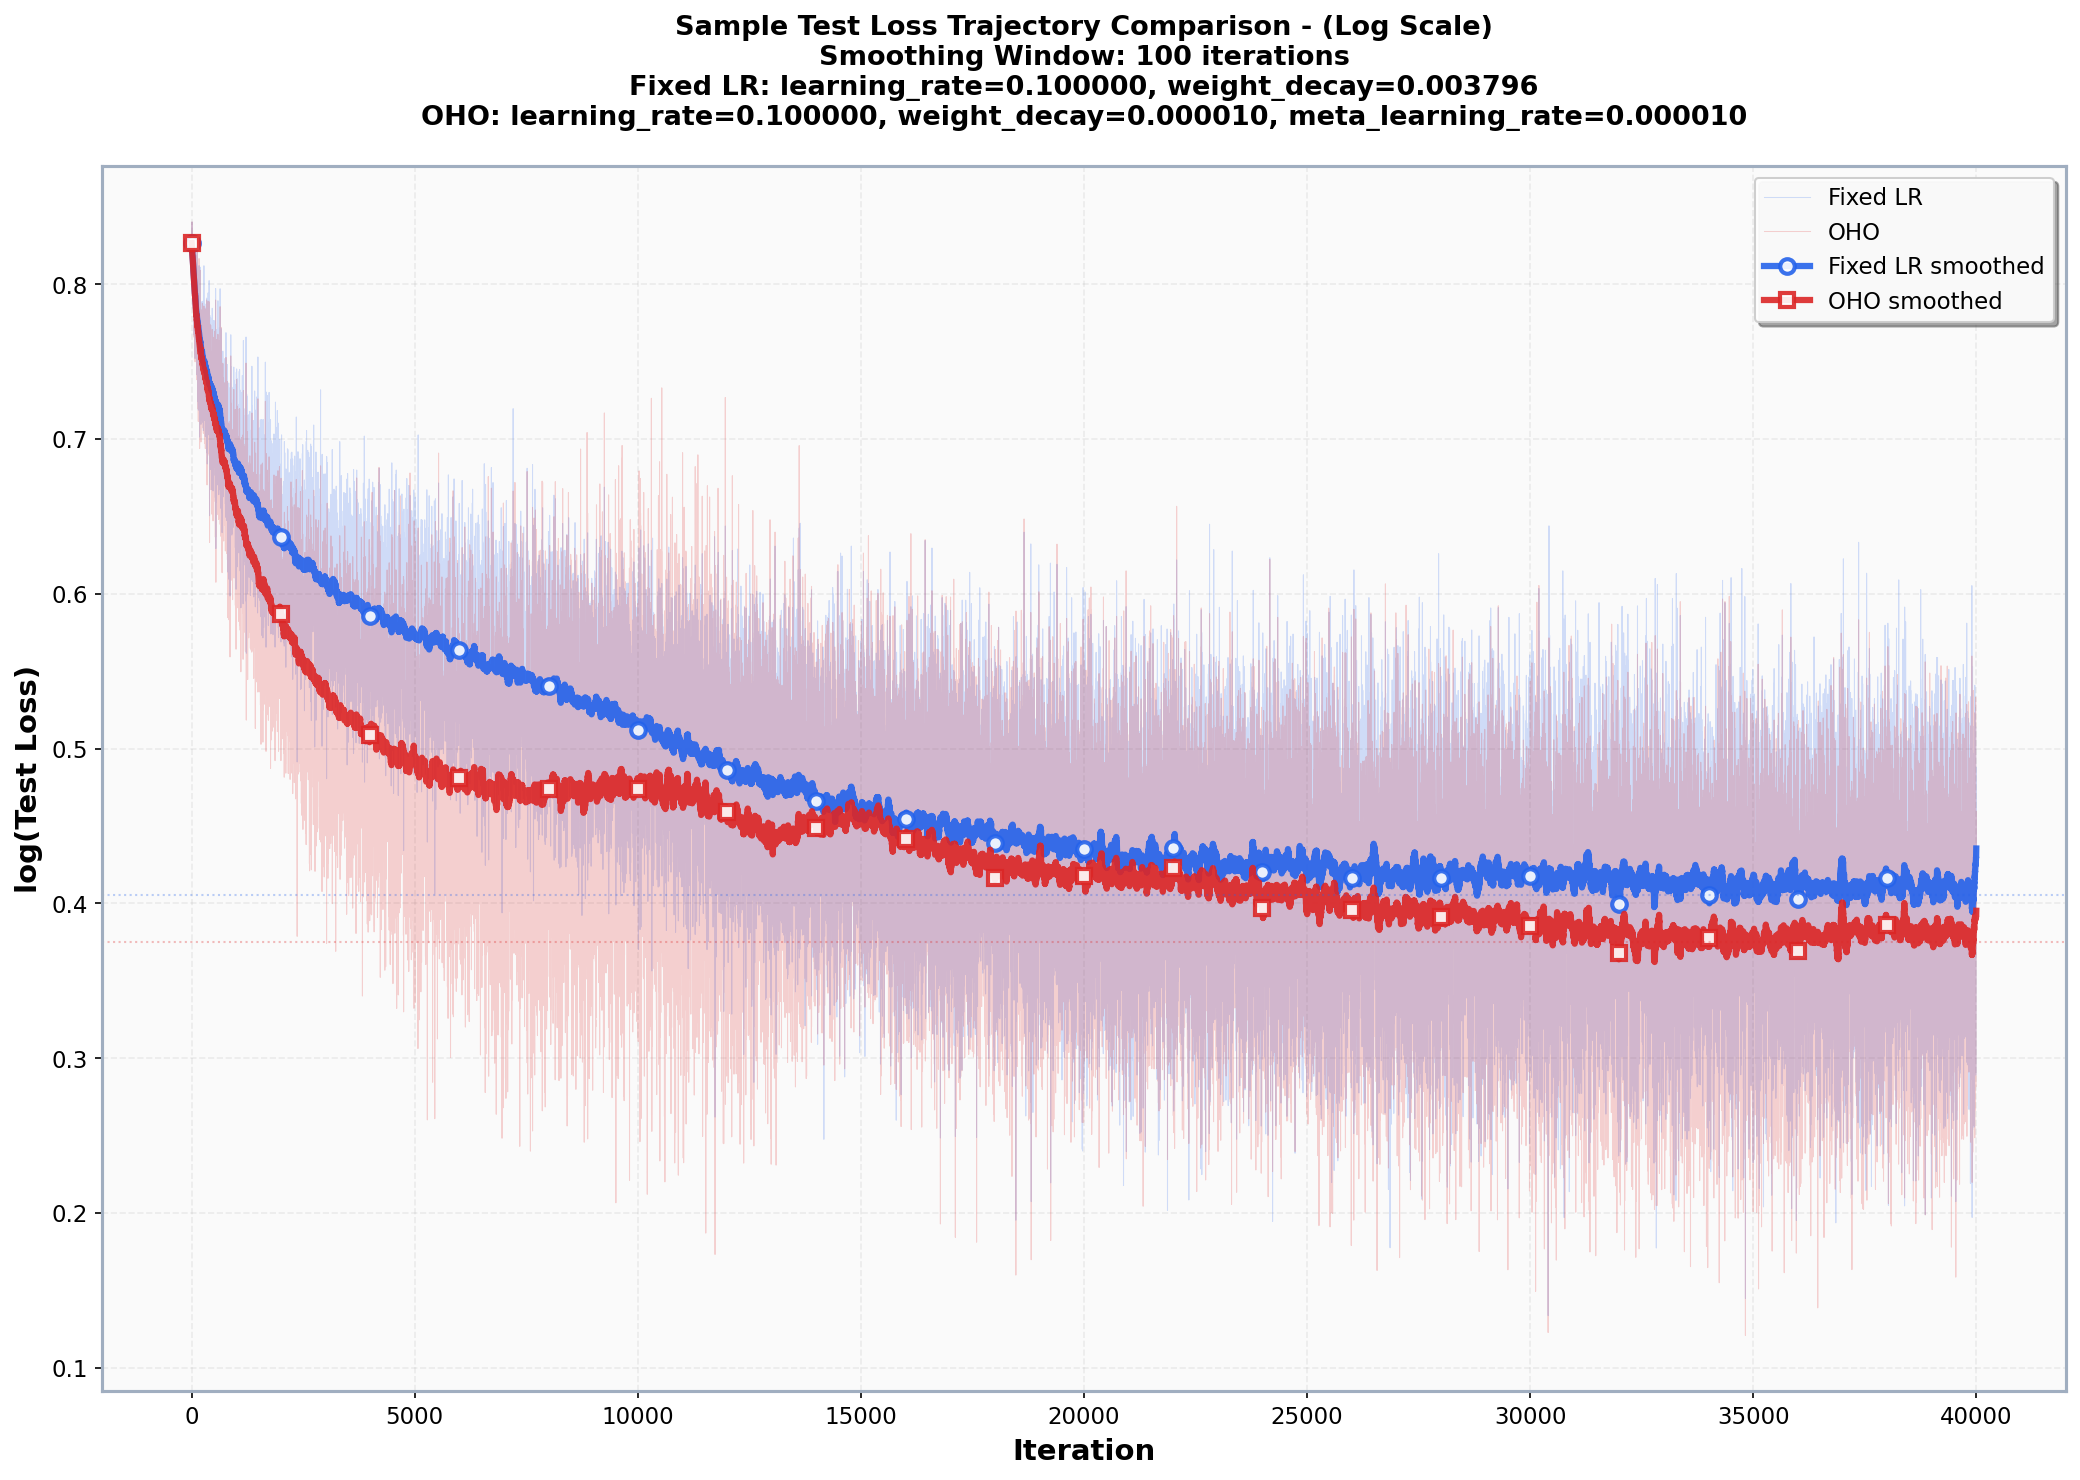

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d

def power_law(t, a, b, c):
    return a * (t + 1) ** (-b) + c

def plot_best_seed_trajectory_comparison(exp1_tuple, exp2_tuple, smoothing_window=100, seed=201):
    """
    Plot test loss trajectories for a specific seed,
    comparing both experiments on the same seed with optional smoothing.
    
    Args:
        exp1_tuple: tuple (name, df_metadata, df_timeseries) for experiment 1 (e.g., fixed LR)
        exp2_tuple: tuple (name, df_metadata, df_timeseries) for experiment 2 (e.g., OHO)
        smoothing_window: Window size for moving average smoothing (default: 100)
        seed: Specific seed to plot (default: 201)
    """
    name1, df_metadata1, df_timeseries1 = exp1_tuple
    name2, df_metadata2, df_timeseries2 = exp2_tuple
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    print(f"\nProcessing {name1}...")
    
    # Get best config for experiment 1
    config_cols = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/1/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    
    available_cols1 = [col for col in config_cols if col in df_metadata1.columns]
    config_summary1 = df_metadata1.groupby(available_cols1)['metric/final_test_loss'].agg(['mean', 'count']).compute()
    config_summary1 = config_summary1.reset_index().sort_values('mean')
    best_config1 = config_summary1.iloc[0]
    
    # Filter to best config for exp1
    mask1 = df_metadata1[available_cols1[0]] == best_config1[available_cols1[0]]
    for col in available_cols1[1:]:
        mask1 &= (df_metadata1[col] == best_config1[col])
    best_metadata1 = df_metadata1[mask1][['task_id', 'config/seed/global_seed', 'metric/final_test_loss']].compute()
    
    print(f"\nProcessing {name2}...")
    
    # Get best config for experiment 2
    available_cols2 = [col for col in config_cols if col in df_metadata2.columns]
    config_summary2 = df_metadata2.groupby(available_cols2)['metric/final_test_loss'].agg(['mean', 'count']).compute()
    config_summary2 = config_summary2.reset_index().sort_values('mean')
    best_config2 = config_summary2.iloc[0]
    
    # Filter to best config for exp2
    mask2 = df_metadata2[available_cols2[0]] == best_config2[available_cols2[0]]
    for col in available_cols2[1:]:
        mask2 &= (df_metadata2[col] == best_config2[col])
    best_metadata2 = df_metadata2[mask2][['task_id', 'config/seed/global_seed', 'metric/final_test_loss']].compute()
    
    # Find common seeds
    seed_to_loss1 = dict(zip(best_metadata1['config/seed/global_seed'], best_metadata1['metric/final_test_loss']))
    seed_to_loss2 = dict(zip(best_metadata2['config/seed/global_seed'], best_metadata2['metric/final_test_loss']))
    seed_to_task1 = dict(zip(best_metadata1['config/seed/global_seed'], best_metadata1['task_id']))
    seed_to_task2 = dict(zip(best_metadata2['config/seed/global_seed'], best_metadata2['task_id']))
    
    common_seeds = set(seed_to_loss1.keys()) & set(seed_to_loss2.keys())
    
    if len(common_seeds) == 0:
        print("No common seeds found!")
        return
    
    # Use the specified seed (convert to same type as in the data)
    # Check what type the seeds are stored as
    sample_seed = list(common_seeds)[0] if common_seeds else None
    if sample_seed is not None:
        if isinstance(sample_seed, str):
            example_seed = str(seed)
        else:
            example_seed = seed
    else:
        print("No common seeds found!")
        return
    
    if example_seed not in common_seeds:
        print(f"Seed {seed} not found in common seeds!")
        print(f"Available common seeds: {sorted(list(common_seeds))[:20]}...")
        return
    
    print(f"\nUsing seed: {seed}")
    print(f"  {name1} final loss: {seed_to_loss1[example_seed]:.6f}")
    print(f"  {name2} final loss: {seed_to_loss2[example_seed]:.6f}")
    
    # Get task IDs for the example seed
    task_id1 = seed_to_task1[example_seed]
    task_id2 = seed_to_task2[example_seed]
    
    # Get timeseries data for both experiments on this seed
    timeseries1 = df_timeseries1[df_timeseries1['task_id'] == task_id1][
        ['iteration', 'metric/test_loss']
    ].compute()
    
    timeseries2 = df_timeseries2[df_timeseries2['task_id'] == task_id2][
        ['iteration', 'metric/test_loss']
    ].compute()
    
    # Sort by iteration
    timeseries1 = timeseries1.sort_values('iteration')
    timeseries2 = timeseries2.sort_values('iteration')
    
    iterations1 = timeseries1['iteration'].values
    test_losses1 = timeseries1['metric/test_loss'].values
    
    iterations2 = timeseries2['iteration'].values
    test_losses2 = timeseries2['metric/test_loss'].values
    
    # Apply smoothing
    if smoothing_window > 1:
        # Use uniform filter for moving average
        smoothed_losses1 = uniform_filter1d(test_losses1, size=smoothing_window, mode='nearest')
        smoothed_losses2 = uniform_filter1d(test_losses2, size=smoothing_window, mode='nearest')
    else:
        smoothed_losses1 = test_losses1
        smoothed_losses2 = test_losses2
    
    # Plot raw trajectories with low alpha (log scale)
    ax.plot(iterations1, np.log(test_losses1), 
            color='#2563eb', linewidth=0.5, alpha=0.2, 
            linestyle='-', label=f'{name1}')
    
    ax.plot(iterations2, np.log(test_losses2), 
            color='#dc2626', linewidth=0.5, alpha=0.2,
            linestyle='-', label=f'{name2}')
    
    # Plot smoothed trajectories (log scale)
    line1 = ax.plot(iterations1, np.log(smoothed_losses1), 
                    color='#2563eb', linewidth=3, alpha=0.9, 
                    label=f'{name1} smoothed', 
                    linestyle='-', marker='o', markevery=len(iterations1)//20, 
                    markersize=7, markerfacecolor='white', markeredgewidth=2)
    
    line2 = ax.plot(iterations2, np.log(smoothed_losses2), 
                    color='#dc2626', linewidth=3, alpha=0.9,
                    label=f'{name2} smoothed', 
                    linestyle='-', marker='s', markevery=len(iterations2)//20,
                    markersize=7, markerfacecolor='white', markeredgewidth=2)
    
    # Format config strings for display
    lr0_1 = float(best_config1['config/learners/0/optimizer/learning_rate/value'])
    wd_1 = float(best_config1['config/learners/0/optimizer/weight_decay/value'])
    config_str1 = f"learning_rate={lr0_1:.6f}, weight_decay={wd_1:.6f}"
    
    lr0_2 = float(best_config2['config/learners/0/optimizer/learning_rate/value'])
    lr_meta_2 = float(best_config2['config/learners/1/optimizer/learning_rate/value'])
    wd_2 = float(best_config2['config/learners/0/optimizer/weight_decay/value'])
    config_str2 = f"learning_rate={lr0_2:.6f}, weight_decay={wd_2:.6f}, meta_learning_rate={lr_meta_2:.6f}"
    
    # Title and labels
    ax.set_xlabel('Iteration', fontsize=14, fontweight='bold')
    ax.set_ylabel('log(Test Loss)', fontsize=14, fontweight='bold')
    
    title_text = (f'Sample Test Loss Trajectory Comparison - (Log Scale)\n'
                  f'Smoothing Window: {smoothing_window} iterations\n'
                  f'{name1}: {config_str1}\n'
                  f'{name2}: {config_str2}')
    ax.set_title(title_text, fontsize=13, fontweight='bold', pad=20)
    
    # Add grid and styling
    ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.8)
    ax.set_facecolor('#FAFAFA')
    ax.set_axisbelow(True)
    
    # Add final loss annotations (in log scale)
    ax.axhline(y=np.log(seed_to_loss1[example_seed]), color='#2563eb', linestyle=':', alpha=0.3, linewidth=1)
    ax.axhline(y=np.log(seed_to_loss2[example_seed]), color='#dc2626', linestyle=':', alpha=0.3, linewidth=1)
    
    # Add text box with final losses
    final_loss_text = (f'Final Test Losses:\n'
                      f'{name1}: {seed_to_loss1[example_seed]:.6f}\n'
                      f'{name2}: {seed_to_loss2[example_seed]:.6f}\n'
                      f'Difference: {seed_to_loss2[example_seed] - seed_to_loss1[example_seed]:.6f}')
    
    # ax.text(0.98, 0.02, final_loss_text, transform=ax.transAxes,
    #        fontsize=11, ha='right', va='bottom',
    #        bbox=dict(boxstyle='round,pad=0.5', 
    #                facecolor='white', alpha=0.95,
    #                edgecolor='#CBD5E0', linewidth=2))
    
    # Legend
    ax.legend(loc='upper right', frameon=True, fancybox=True, 
             shadow=True, framealpha=0.95, fontsize=11)
    
    # Enhance spine styling
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color('#A0AEC0')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Example usage:
fig = plot_best_seed_trajectory_comparison(experiments[0], experiments[1], smoothing_window=100, seed=842)
# Or use defaults:
# fig = plot_best_seed_trajectory_comparison(experiments[0], experiments[1])
# fig.savefig('seed_trajectory_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_3d_loss_landscape(exp1_tuple, exp2_tuple):
    """
    Plot loss-difference landscape only.
    NO TRAJECTORIES.
    """
    name1, df_metadata1, df_timeseries1 = exp1_tuple
    name2, df_metadata2, df_timeseries2 = exp2_tuple
    
    print(f"\nProcessing experiment 1: {name1}...")
    
    # For exp1: group by LR and WD
    config_cols1 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    available_cols1 = [col for col in config_cols1 if col in df_metadata1.columns]
    if len(available_cols1) < 2:
        print("Missing LR/WD columns.")
        return
    
    config_summary1 = (
        df_metadata1.groupby(available_cols1)['metric/final_test_loss']
        .agg(['mean'])
        .compute()
        .reset_index()
    )
    
    lrs = config_summary1[available_cols1[0]].astype(float).values
    wds = config_summary1[available_cols1[1]].astype(float).values
    losses = config_summary1['mean'].values
    
    print(f"\nProcessing experiment 2: {name2}...")
    
    # Best config for exp2
    config_cols2 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/1/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    available_cols2 = [c for c in config_cols2 if c in df_metadata2.columns]
    
    config_summary2 = (
        df_metadata2.groupby(available_cols2)['metric/final_test_loss']
        .agg(['mean'])
        .compute()
        .reset_index()
        .sort_values('mean')
    )
    best_config2 = config_summary2.iloc[0]
    best_loss2 = best_config2['mean']
    
    print(f"Best {name2} mean loss = {best_loss2:.6f}")
    
    # Compute difference grid
    loss_differences = losses - best_loss2
    
    lr_unique = np.sort(np.unique(lrs))
    wd_unique = np.sort(np.unique(wds))
    LR_grid, WD_grid = np.meshgrid(lr_unique, wd_unique)
    Diff_grid = np.full(LR_grid.shape, np.nan)
    
    for i, lr in enumerate(lr_unique):
        for j, wd in enumerate(wd_unique):
            mask = (lrs == lr) & (wds == wd)
            if np.any(mask):
                Diff_grid[j, i] = loss_differences[mask][0]
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    max_abs_diff = np.nanmax(np.abs(loss_differences))
    
    im = ax.pcolormesh(
        LR_grid, WD_grid, Diff_grid,
        cmap='RdBu_r', shading='auto',
        vmin=-max_abs_diff, vmax=max_abs_diff
    )

    
    
    # zero contour
    ax.contour(
        LR_grid, WD_grid, Diff_grid,
        levels=[0], colors='black',
        linewidths=2, linestyles='--'
    )
    
    # scatter config points
    ax.scatter(
        lrs, wds, c=loss_differences,
        cmap='RdBu_r', s=60, edgecolors='black',
        vmin=-max_abs_diff, vmax=max_abs_diff
    )
    
    cbar = fig.colorbar(im, ax=ax, pad=0.02, aspect=30)
    cbar.set_label(f'Loss Difference\n({name1} − {name2})',
                fontsize=13, rotation=270, labelpad=25, fontweight='bold')

    # The heatmap scale
    vmin, vmax = im.get_clim()
    mid = 0.0

    # Add a clear zero separator
    cbar.ax.axhline(y=0, color='black', linewidth=2)

    # Pick colors DIRECTLY from the colormap to avoid mismatches
    cmap = plt.get_cmap('RdBu_r')
    better_color = cmap( (vmin - vmin) / (vmax - vmin) )   # bottom = blue
    worse_color  = cmap( (vmax - vmin) / (vmax - vmin) )   # top = red

    # Label positions (slightly inset from edges)
    cbar.ax.text(
        1.2, vmin * 0.6, f"{name1}\nBetter",
        ha='left', va='center', fontsize=11,
        color=better_color, fontweight='bold', transform=cbar.ax.transData
    )

    cbar.ax.text(
        1.2, vmax * 0.6, f"{name1}\nWorse",
        ha='left', va='center', fontsize=11,
        color=worse_color, fontweight='bold', transform=cbar.ax.transData
    )
    
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Weight Decay')
    ax.set_title(f'{name1} vs {name2}: Loss-Difference Landscape\n(Blue: {name1} better, Red: {name1} worse)')
    
    # log scaling if meaningful
    if lrs.min() > 0 and lrs.max()/lrs.min() > 10:
        ax.set_xscale('log')
    if wds.min() > 0 and wds.max()/wds.min() > 10:
        ax.set_yscale('log')
    
    ax.grid(True, linestyle=':', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_3d_loss_landscape(experiments[0], experiments[1])


NameError: name 'experiments' is not defined

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches

def plot_3d_loss_landscape_with_trajectory(exp1_tuple, exp2_tuple, seed=201):
    """
    Plot difference heatmap showing (OHO − Fixed LR) loss for each config,
    with trajectory of best OHO config's LR and WD over training iterations.
    """
    name1, df_metadata1, df_timeseries1 = exp1_tuple
    name2, df_metadata2, df_timeseries2 = exp2_tuple
    
    print(f"\nProcessing experiment 1 (Fixed LR): {name1}...")
    
    # For exp1: group by LR and weight decay
    config_cols1 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    available_cols1 = [col for col in config_cols1 if col in df_metadata1.columns]
    if len(available_cols1) < 2:
        print(f"Error: Need both learning rate and weight decay columns")
        print(f"Available columns: {available_cols1}")
        return
    
    config_summary1 = df_metadata1.groupby(available_cols1)['metric/final_test_loss'].agg(['mean', 'std', 'count']).compute()
    config_summary1 = config_summary1.reset_index()
    
    print(f"  Found {len(config_summary1)} unique configs in experiment 1")
    
    lrs = config_summary1[available_cols1[0]].astype(float).values
    wds = config_summary1[available_cols1[1]].astype(float).values
    losses = config_summary1['mean'].values
    
    print(f"  LR range: {lrs.min():.6f} to {lrs.max():.6f}")
    print(f"  WD range: {wds.min():.6f} to {wds.max():.6f}")
    print(f"  Loss range: {losses.min():.6f} to {losses.max():.6f}")
    
    print(f"\nProcessing experiment 2 (OHO): {name2}...")
    
    config_cols2 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/1/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    available_cols2 = [col for col in config_cols2 if col in df_metadata2.columns]
    config_summary2 = df_metadata2.groupby(available_cols2)['metric/final_test_loss'].agg(['mean', 'count']).compute()
    config_summary2 = config_summary2.reset_index().sort_values('mean')
    best_config2 = config_summary2.iloc[0]
    best_loss2 = best_config2['mean']
    
    lr0 = float(best_config2['config/learners/0/optimizer/learning_rate/value'])
    lr_meta = float(best_config2['config/learners/1/optimizer/learning_rate/value'])
    wd = float(best_config2['config/learners/0/optimizer/weight_decay/value'])
    config_str2 = f"lr={lr0:.6f}, wd={wd:.6f}, meta_lr={lr_meta:.6f}"
    
    print(f"  Best config 2 (OHO): {config_str2}")
    print(f"  Best mean final test loss: {best_loss2:.6f}")
    
    # Get trajectory
    print(f"\nGetting trajectory for seed {seed} with best {name2} config...")
    mask_meta = df_metadata2[available_cols2[0]] == best_config2[available_cols2[0]]
    for col in available_cols2[1:]:
        if col in df_metadata2.columns:
            mask_meta &= (df_metadata2[col] == best_config2[col])
    
    mask_meta &= ((df_metadata2['config/seed/global_seed'] == seed) |
                  (df_metadata2['config/seed/global_seed'] == str(seed)))
    
    best_metadata = df_metadata2[mask_meta][['task_id', 'config/seed/global_seed', 'metric/final_test_loss']].compute()
    
    trajectory_lr, trajectory_wd = None, None
    if len(best_metadata) > 0:
        task_id = best_metadata['task_id'].values[0]
        print(f"  Found task {task_id} for seed {seed}")
        
        task_data = df_timeseries2[df_timeseries2['task_id'] == task_id].compute()
        task_data = task_data.sort_values('iteration')
        
        lr_col = 'metric/train_recurrent_learning_rate'
        wd_col = 'metric/train_recurrent_weight_decay'
        
        if lr_col in task_data.columns and wd_col in task_data.columns:
            trajectory_lr = task_data[lr_col].values
            trajectory_wd = task_data[wd_col].values
            valid_mask = ~(np.isnan(trajectory_lr) | np.isnan(trajectory_wd))
            trajectory_lr = trajectory_lr[valid_mask]
            trajectory_wd = trajectory_wd[valid_mask]
            print(f"  Trajectory: {len(trajectory_lr)} points")
        else:
            print(f"  Warning: Could not find trajectory columns")
    else:
        print(f"  Warning: No data found for seed {seed} with best config")
    
    # Calculate differences (OHO − Fixed)
    loss_differences = best_loss2 - losses
    
    lr_unique = np.sort(np.unique(lrs))
    wd_unique = np.sort(np.unique(wds))
    LR_grid, WD_grid = np.meshgrid(lr_unique, wd_unique)
    Diff_grid = np.full(LR_grid.shape, np.nan)
    for i, lr in enumerate(lr_unique):
        for j, wd in enumerate(wd_unique):
            mask = (lrs == lr) & (wds == wd)
            if np.any(mask):
                Diff_grid[j, i] = loss_differences[mask][0]
    
    # Plot setup
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['font.size'] = 11
    plt.rcParams['font.family'] = 'sans-serif'
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('#FAFAFA')
    
    cmap = 'RdBu'  # red = worse, blue = better
    max_abs_diff = np.nanmax(np.abs(loss_differences))
    
    im = ax.pcolormesh(LR_grid, WD_grid, Diff_grid, cmap=cmap, shading='gouraud',
                       vmin=-max_abs_diff, vmax=max_abs_diff, alpha=0.85)
    
    contour_levels = np.linspace(-max_abs_diff, max_abs_diff, 9)
    ax.contour(LR_grid, WD_grid, Diff_grid, levels=contour_levels,
               colors='gray', linewidths=0.5, alpha=0.3)
    
    zero_contour = ax.contour(LR_grid, WD_grid, Diff_grid, levels=[0],
                              colors='black', linewidths=2.5, linestyles='-', alpha=0.7)
    ax.clabel(zero_contour, inline=True, fontsize=10, fmt='Equal')
    
    ax.scatter(lrs, wds, c=loss_differences, cmap=cmap, s=80, edgecolors='white',
               linewidths=1.5, vmin=-max_abs_diff, vmax=max_abs_diff, zorder=5, alpha=0.9)
    
    # Trajectory line
    if trajectory_lr is not None and trajectory_wd is not None:
        if len(trajectory_lr) > 100:
            idx = np.linspace(0, len(trajectory_lr)-1, 100, dtype=int)
            traj_lr_plot, traj_wd_plot = trajectory_lr[idx], trajectory_wd[idx]
        else:
            traj_lr_plot, traj_wd_plot = trajectory_lr, trajectory_wd
        
        ax.plot(traj_lr_plot, traj_wd_plot, color='#7C3AED', linewidth=3.5,
                zorder=15, alpha=0.9, linestyle='-', label=f'Sample OHO Trajectory')
        
        # Arrows
        n_arrows = 5
        arrow_indices = np.linspace(10, len(traj_lr_plot)-10, n_arrows, dtype=int)
        for idx in arrow_indices:
            if idx < len(traj_lr_plot) - 1:
                ax.annotate('', xy=(traj_lr_plot[idx+1], traj_wd_plot[idx+1]),
                            xytext=(traj_lr_plot[idx], traj_wd_plot[idx]),
                            arrowprops=dict(arrowstyle='->', color='#7C3AED', lw=2, alpha=0.7))
        
        # Start/end points (smaller markers)
        ax.scatter(traj_lr_plot[0], traj_wd_plot[0], s=200, c='#10B981', marker='o',
                   edgecolors='white', linewidths=2, zorder=20, label='Start', alpha=1)
        ax.scatter(traj_lr_plot[-1], traj_wd_plot[-1], s=200, c='#EF4444', marker='s',
                   edgecolors='white', linewidths=2, zorder=20, label='End', alpha=1)
        
        ax.annotate('START', xy=(traj_lr_plot[0], traj_wd_plot[0]), xytext=(-50, 0),
                    textcoords='offset points', fontsize=10, fontweight='bold', color='#10B981',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#10B981', linewidth=2, alpha=0.9))
        ax.annotate('END', xy=(traj_lr_plot[-1], traj_wd_plot[-1]), xytext=(-40, 0),
                    textcoords='offset points', fontsize=10, fontweight='bold', color='#EF4444',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#EF4444', linewidth=2, alpha=0.9))
    
    # Colorbar
    cbar = fig.colorbar(im, ax=ax, pad=0.02, aspect=30)
    cbar.set_label(f'Loss Difference\n({name2} − {name1})',
                   fontsize=13, rotation=270, labelpad=30, fontweight='bold')
    cbar.ax.axhline(y=0, color='black', linewidth=2.5)
    cbar.ax.text(1.5, max_abs_diff * 0.5, f'{name2}\nWorse', fontsize=10, ha='left', va='center',
                 fontweight='bold', color='#DC2626')
    cbar.ax.text(1.5, -max_abs_diff * 0.5, f'{name2}\nBetter', fontsize=10, ha='left', va='center',
                 fontweight='bold', color='#2563EB')
    
    # Labels and title
    ax.set_xlabel('Learning Rate', fontsize=14, fontweight='bold')
    ax.set_ylabel('Weight Decay', fontsize=14, fontweight='bold')
    title = f'Loss Landscape Comparison: {name2} vs {name1}\n'
    title += f'{name2} Best Config: {config_str2}\nBest Loss = {best_loss2:.6f}'
    ax.set_title(title, fontsize=15, fontweight='bold', pad=20)
    
    if lrs.min() > 0 and lrs.max() / lrs.min() > 10:
        ax.set_xscale('log')
    if wds.min() > 0 and wds.max() / wds.min() > 10:
        ax.set_yscale('log')
    
    ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.8, color='gray')
    ax.set_axisbelow(True)
    
    if trajectory_lr is not None:
        legend = ax.legend(loc='upper left', fontsize=11, frameon=True, fancybox=True, shadow=True,
                           framealpha=0.95, edgecolor='#CBD5E0', facecolor='white', markerscale=0.8)
        legend.get_frame().set_linewidth(2)
    
    # Statistics box (moved to bottom-left)
    stats_text = f'Statistics:\n'
    stats_text += f'{name1} best: {losses.min():.6f}\n'
    stats_text += f'{name2} best: {best_loss2:.6f}\n'
    stats_text += f'Difference (OHO − fixed best): {best_loss2 - losses.min():.6f}\n'
    stats_text += f'Configs where OHO better: {np.sum(loss_differences < 0)}/{len(loss_differences)}'
    
    # ax.text(0.02, 0.02, stats_text, transform=ax.transAxes, fontsize=10, ha='left', va='bottom',
    #        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#CBD5E0',
    #                  linewidth=2, alpha=0.95))
    
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color('#A0AEC0')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nComparison Summary:")
    print(f"  {name1} best loss: {losses.min():.6f}")
    print(f"  {name2} best loss: {best_loss2:.6f}")
    print(f"  Difference (OHO - fixed best): {best_loss2 - losses.min():.6f}")
    print(f"  Configs where OHO better: {np.sum(loss_differences < 0)}/{len(loss_differences)}")
    print(f"  Configs where fixed better: {np.sum(loss_differences > 0)}/{len(loss_differences)}")
    print(f"  Mean difference (OHO - fixed): {np.mean(loss_differences):.6f}")
    
    return fig


# Example usage:
fig = plot_3d_loss_landscape_with_trajectory(experiments[0], experiments[1], seed=2)


NameError: name 'experiments' is not defined

In [13]:
import numpy as np
from scipy.stats import mannwhitneyu

def compare_experiments_mann_whitney(experiments):
    """
    Compare experiments pairwise using Mann-Whitney U test for:
    - Final test loss
    - Effective learning rate (decay rate b)
    - Asymptotic loss (c parameter)
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
    """
    n_experiments = len(experiments)
    
    # Collect data for each experiment's best config
    experiment_data = []
    
    for name, df_metadata, df_timeseries in experiments:
        print(f"\nProcessing {name}...")
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value'
        ]
        
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            continue
        
        # Get best config
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]
        
        # Filter to best config
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id', 'metric/final_test_loss']].compute()
        
        final_losses = best_metadata['metric/final_test_loss'].dropna().values
        best_task_ids = best_metadata['task_id'].values
        
        # Compute effective LRs and asymptotes
        eff_lrs = []
        asymptotes = []
        chunk_size = 10
        
        for i in range(0, len(best_task_ids), chunk_size):
            chunk_ids = best_task_ids[i:i+chunk_size]
            chunk_timeseries = df_timeseries[df_timeseries['task_id'].isin(chunk_ids.tolist())][['task_id', 'iteration', 'metric/test_loss']].compute()
            
            for task_id in chunk_ids:
                task_data = chunk_timeseries[chunk_timeseries['task_id'] == task_id]
                if len(task_data) > 5:
                    try:
                        from scipy.optimize import curve_fit
                        iterations = task_data['iteration'].values
                        test_losses = task_data['metric/test_loss'].dropna().values
                        if len(test_losses) > 5:
                            popt, _ = curve_fit(power_law, iterations[:len(test_losses)], test_losses,
                                              bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
                            eff_lrs.append(popt[1])
                            asymptotes.append(popt[2])
                    except:
                        continue
        
        experiment_data.append({
            'name': name,
            'final_losses': np.array(final_losses),
            'eff_lrs': np.array(eff_lrs),
            'asymptotes': np.array(asymptotes)
        })
    
    # Pairwise comparisons
    print(f"\n{'='*80}")
    print("MANN-WHITNEY U TEST RESULTS (Pairwise Comparisons)")
    print(f"{'='*80}\n")
    
    for i in range(n_experiments):
        for j in range(i + 1, n_experiments):
            name1 = experiment_data[i]['name']
            name2 = experiment_data[j]['name']
            
            print(f"\n{name1} vs {name2}")
            print("-" * 80)
            
            # Final test loss (lower is better)
            stat, p = mannwhitneyu(experiment_data[i]['final_losses'], 
                                   experiment_data[j]['final_losses'], 
                                   alternative='two-sided')
            median1 = np.median(experiment_data[i]['final_losses'])
            median2 = np.median(experiment_data[j]['final_losses'])
            winner = name1 if median1 < median2 else name2
            print(f"Final Test Loss:")
            print(f"  U-statistic: {stat:.2f}")
            print(f"  p-value: {p:.6f}")
            print(f"  Significant (p<0.05): {'YES' if p < 0.05 else 'NO'}")
            print(f"  Medians: {median1:.6f} vs {median2:.6f}")
            print(f"  WINNER: {winner} (lower is better)")
            
            # Effective learning rate (higher is better - faster convergence)
            if len(experiment_data[i]['eff_lrs']) > 0 and len(experiment_data[j]['eff_lrs']) > 0:
                stat, p = mannwhitneyu(experiment_data[i]['eff_lrs'], 
                                       experiment_data[j]['eff_lrs'], 
                                       alternative='two-sided')
                median1 = np.median(experiment_data[i]['eff_lrs'])
                median2 = np.median(experiment_data[j]['eff_lrs'])
                winner = name1 if median1 > median2 else name2
                print(f"\nEffective Learning Rate (Decay Rate b):")
                print(f"  U-statistic: {stat:.2f}")
                print(f"  p-value: {p:.6f}")
                print(f"  Significant (p<0.05): {'YES' if p < 0.05 else 'NO'}")
                print(f"  Medians: {median1:.6f} vs {median2:.6f}")
                print(f"  WINNER: {winner} (higher is better)")
            else:
                print(f"\nEffective Learning Rate: Insufficient data")
            
            # Asymptotic loss (lower is better)
            if len(experiment_data[i]['asymptotes']) > 0 and len(experiment_data[j]['asymptotes']) > 0:
                stat, p = mannwhitneyu(experiment_data[i]['asymptotes'], 
                                       experiment_data[j]['asymptotes'], 
                                       alternative='two-sided')
                median1 = np.median(experiment_data[i]['asymptotes'])
                median2 = np.median(experiment_data[j]['asymptotes'])
                winner = name1 if median1 < median2 else name2
                print(f"\nAsymptotic Loss (c):")
                print(f"  U-statistic: {stat:.2f}")
                print(f"  p-value: {p:.6f}")
                print(f"  Significant (p<0.05): {'YES' if p < 0.05 else 'NO'}")
                print(f"  Medians: {median1:.6f} vs {median2:.6f}")
                print(f"  WINNER: {winner} (lower is better)")
            else:
                print(f"\nAsymptotic Loss: Insufficient data")

compare_experiments_mann_whitney(experiments)


Processing Fixed LR...

Processing OHO...

MANN-WHITNEY U TEST RESULTS (Pairwise Comparisons)


Fixed LR vs OHO
--------------------------------------------------------------------------------
Final Test Loss:
  U-statistic: 315.00
  p-value: 0.001953
  Significant (p<0.05): YES
  Medians: 1.499170 vs 1.482625
  WINNER: OHO (lower is better)

Effective Learning Rate (Decay Rate b):
  U-statistic: 79.00
  p-value: 0.001116
  Significant (p<0.05): YES
  Medians: 0.075627 vs 0.101196
  WINNER: OHO (higher is better)

Asymptotic Loss (c):
  U-statistic: 0.00
  p-value: 0.000000
  Significant (p<0.05): YES
  Medians: 0.000000 vs 0.595703
  WINNER: Fixed LR (lower is better)


In [12]:
import numpy as np
from scipy.stats import ttest_rel, ttest_1samp
import pandas as pd

def compare_experiments_t_test(experiments):
    """
    Compare experiments pairwise using paired t-test to test if mean difference is zero for:
    - Final test loss
    - Effective learning rate (decay rate b)
    - Asymptotic loss (c parameter)
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
    """
    n_experiments = len(experiments)
    
    # Helper function for power law fitting
    def power_law(x, a, b, c):
        return a * np.power(x, -b) + c
    
    # Collect data for each experiment's best config
    experiment_data = []
    
    for name, df_metadata, df_timeseries in experiments:
        print(f"\nProcessing {name}...")
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value'
        ]
        
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            continue
        
        # Get best config
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]
        
        # Filter to best config
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id', 'config/seed/global_seed', 'metric/final_test_loss']].compute()
        
        # Store with seeds for pairing
        seed_to_loss = dict(zip(best_metadata['config/seed/global_seed'], 
                                best_metadata['metric/final_test_loss']))
        
        best_task_ids = best_metadata['task_id'].values
        seed_to_task = dict(zip(best_metadata['config/seed/global_seed'], 
                               best_metadata['task_id']))
        
        # Compute effective LRs and asymptotes
        seed_to_eff_lr = {}
        seed_to_asymptote = {}
        chunk_size = 10
        
        for i in range(0, len(best_task_ids), chunk_size):
            chunk_ids = best_task_ids[i:i+chunk_size]
            chunk_timeseries = df_timeseries[df_timeseries['task_id'].isin(chunk_ids.tolist())][
                ['task_id', 'iteration', 'metric/test_loss']
            ].compute()
            
            for task_id in chunk_ids:
                # Find seed for this task_id
                seed = [s for s, t in seed_to_task.items() if t == task_id]
                if not seed:
                    continue
                seed = seed[0]
                
                task_data = chunk_timeseries[chunk_timeseries['task_id'] == task_id]
                if len(task_data) > 5:
                    try:
                        from scipy.optimize import curve_fit
                        iterations = task_data['iteration'].values
                        test_losses = task_data['metric/test_loss'].dropna().values
                        if len(test_losses) > 5:
                            popt, _ = curve_fit(power_law, iterations[:len(test_losses)], test_losses,
                                              bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
                            seed_to_eff_lr[seed] = popt[1]
                            seed_to_asymptote[seed] = popt[2]
                    except:
                        continue
        
        experiment_data.append({
            'name': name,
            'seed_to_loss': seed_to_loss,
            'seed_to_eff_lr': seed_to_eff_lr,
            'seed_to_asymptote': seed_to_asymptote
        })
    
    # Pairwise comparisons using paired t-test
    print(f"\n{'='*80}")
    print("PAIRED T-TEST RESULTS (Testing if mean difference = 0)")
    print(f"{'='*80}\n")
    
    for i in range(n_experiments):
        for j in range(i + 1, n_experiments):
            name1 = experiment_data[i]['name']
            name2 = experiment_data[j]['name']
            
            print(f"\n{name1} vs {name2}")
            print("-" * 80)
            
            # Find common seeds
            common_seeds = set(experiment_data[i]['seed_to_loss'].keys()) & \
                          set(experiment_data[j]['seed_to_loss'].keys())
            common_seeds = sorted(common_seeds)
            
            if len(common_seeds) == 0:
                print("No common seeds found for comparison")
                continue
            
            print(f"Number of paired samples: {len(common_seeds)}")
            
            # Final test loss comparison
            losses1 = np.array([experiment_data[i]['seed_to_loss'][s] for s in common_seeds])
            losses2 = np.array([experiment_data[j]['seed_to_loss'][s] for s in common_seeds])
            differences = losses2 - losses1  # exp2 - exp1
            
            # One-sample t-test to test if mean difference is zero
            t_stat, p_value = ttest_1samp(differences, 0)
            
            print(f"\nFinal Test Loss Difference ({name2} - {name1}):")
            print(f"  Mean difference: {np.mean(differences):.6f}")
            print(f"  Std of differences: {np.std(differences, ddof=1):.6f}")
            print(f"  95% CI: [{np.mean(differences) - 1.96*np.std(differences)/np.sqrt(len(differences)):.6f}, "
                  f"{np.mean(differences) + 1.96*np.std(differences)/np.sqrt(len(differences)):.6f}]")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.6f}")
            print(f"  Reject null (mean=0) at α=0.05: {'YES' if p_value < 0.05 else 'NO'}")
            if p_value < 0.05:
                if np.mean(differences) < 0:
                    print(f"  Conclusion: {name2} is significantly better (lower loss)")
                else:
                    print(f"  Conclusion: {name1} is significantly better (lower loss)")
            else:
                print(f"  Conclusion: No significant difference")
            
            # Effective learning rate comparison
            common_seeds_lr = set(experiment_data[i]['seed_to_eff_lr'].keys()) & \
                             set(experiment_data[j]['seed_to_eff_lr'].keys())
            common_seeds_lr = sorted(common_seeds_lr)
            
            if len(common_seeds_lr) > 0:
                eff_lrs1 = np.array([experiment_data[i]['seed_to_eff_lr'][s] for s in common_seeds_lr])
                eff_lrs2 = np.array([experiment_data[j]['seed_to_eff_lr'][s] for s in common_seeds_lr])
                differences_lr = eff_lrs2 - eff_lrs1
                
                t_stat, p_value = ttest_1samp(differences_lr, 0)
                
                print(f"\nEffective Learning Rate Difference ({name2} - {name1}):")
                print(f"  Number of paired samples: {len(common_seeds_lr)}")
                print(f"  Mean difference: {np.mean(differences_lr):.6f}")
                print(f"  Std of differences: {np.std(differences_lr, ddof=1):.6f}")
                print(f"  95% CI: [{np.mean(differences_lr) - 1.96*np.std(differences_lr)/np.sqrt(len(differences_lr)):.6f}, "
                      f"{np.mean(differences_lr) + 1.96*np.std(differences_lr)/np.sqrt(len(differences_lr)):.6f}]")
                print(f"  t-statistic: {t_stat:.4f}")
                print(f"  p-value: {p_value:.6f}")
                print(f"  Reject null (mean=0) at α=0.05: {'YES' if p_value < 0.05 else 'NO'}")
                if p_value < 0.05:
                    if np.mean(differences_lr) > 0:
                        print(f"  Conclusion: {name2} has significantly higher effective LR (faster convergence)")
                    else:
                        print(f"  Conclusion: {name1} has significantly higher effective LR (faster convergence)")
                else:
                    print(f"  Conclusion: No significant difference")
            else:
                print(f"\nEffective Learning Rate: No common seeds with curve fits")
            
            # Asymptotic loss comparison
            common_seeds_asymp = set(experiment_data[i]['seed_to_asymptote'].keys()) & \
                                set(experiment_data[j]['seed_to_asymptote'].keys())
            common_seeds_asymp = sorted(common_seeds_asymp)
            
            if len(common_seeds_asymp) > 0:
                asymptotes1 = np.array([experiment_data[i]['seed_to_asymptote'][s] for s in common_seeds_asymp])
                asymptotes2 = np.array([experiment_data[j]['seed_to_asymptote'][s] for s in common_seeds_asymp])
                differences_asymp = asymptotes2 - asymptotes1
                
                t_stat, p_value = ttest_1samp(differences_asymp, 0)
                
                print(f"\nAsymptotic Loss Difference ({name2} - {name1}):")
                print(f"  Number of paired samples: {len(common_seeds_asymp)}")
                print(f"  Mean difference: {np.mean(differences_asymp):.6f}")
                print(f"  Std of differences: {np.std(differences_asymp, ddof=1):.6f}")
                print(f"  95% CI: [{np.mean(differences_asymp) - 1.96*np.std(differences_asymp)/np.sqrt(len(differences_asymp)):.6f}, "
                      f"{np.mean(differences_asymp) + 1.96*np.std(differences_asymp)/np.sqrt(len(differences_asymp)):.6f}]")
                print(f"  t-statistic: {t_stat:.4f}")
                print(f"  p-value: {p_value:.6f}")
                print(f"  Reject null (mean=0) at α=0.05: {'YES' if p_value < 0.05 else 'NO'}")
                if p_value < 0.05:
                    if np.mean(differences_asymp) < 0:
                        print(f"  Conclusion: {name2} has significantly lower asymptotic loss")
                    else:
                        print(f"  Conclusion: {name1} has significantly lower asymptotic loss")
                else:
                    print(f"  Conclusion: No significant difference")
            else:
                print(f"\nAsymptotic Loss: No common seeds with curve fits")
    
    print(f"\n{'='*80}")
    print("Summary: Tests whether the mean difference between paired observations is zero.")
    print("If p < 0.05, we reject the null hypothesis that the mean difference is zero.")
    print(f"{'='*80}")

# Example usage:
compare_experiments_t_test(experiments)


Processing Fixed LR...

Processing OHO...

PAIRED T-TEST RESULTS (Testing if mean difference = 0)


Fixed LR vs OHO
--------------------------------------------------------------------------------
Number of paired samples: 20

Final Test Loss Difference (OHO - Fixed LR):
  Mean difference: -0.023063
  Std of differences: 0.020424
  95% CI: [-0.031788, -0.014339]
  t-statistic: -5.0501
  p-value: 0.000071
  Reject null (mean=0) at α=0.05: YES
  Conclusion: OHO is significantly better (lower loss)

Effective Learning Rate Difference (OHO - Fixed LR):
  Number of paired samples: 20
  Mean difference: 0.019002
  Std of differences: 0.020114
  95% CI: [0.010410, 0.027595]
  t-statistic: 4.2249
  p-value: 0.000458
  Reject null (mean=0) at α=0.05: YES
  Conclusion: OHO has significantly higher effective LR (faster convergence)

Asymptotic Loss Difference (OHO - Fixed LR):
  Number of paired samples: 20
  Mean difference: 0.481985
  Std of differences: 0.295305
  95% CI: [0.355839, 0.608131]